# Homework 03: Learning Curves and Training Workflow

## Due: Midnight on September 21 (with 2-hour grace period)

**Points:** 85

In this assignment, you will learn how to design, train, and evaluate neural networks by systematically exploring key design choices. Your focus will be on developing an effective **training workflow** — using learning curves and validation metrics to guide your decisions.

We'll use the **Forest Cover Type (Covertype) dataset,** which has ~581k tabular records with 54 cartographic/topographic features (elevation, aspect, slope, soil and wilderness indicators) used to predict one of seven tree cover types in Colorado’s Roosevelt National Forest. It’s a large, mildly imbalanced multi-class benchmark commonly used to compare classical ML and deep learning on tabular data.

We will start with a **baseline model** (two hidden layers of sizes 64 and 32), and gradually introduce and tune different hyperparameters. Each of the first five problems considers  different hyperparameter choices, and the last problem is your chance to use what you have learned to design your best model:

1. **Activation function** – Compare ReLU, sigmoid, and tanh to see which provides the best accuracy.
2. **Learning rate** – Explore a range of learning rates and identify which balances convergence speed and stability.
3. **Dropout** – Investigate how different dropout rates reduce overfitting and where they are most effective.
4. **L2 regularization** – Experiment with weight penalties to encourage simpler models and avoid memorization.
5. **Dropout + L2** – Combine both regularization techniques and study their interaction.
6. **Best model design** – Use all your insights to build and train your strongest model, with the option to try **learning rate scheduling** for further improvement.

Throughout, you will use **early stopping** to select the model at the epoch of **minimum validation loss**, and you will report the **validation accuracy** of that selected model as the primary measure of performance.

By the end of this homework, you will not only understand how different hyperparameters affect training and generalization, but also gain hands-on practice in building a disciplined workflow for model development.

There are 10 graded problems, worth 8 points each, with 5 points for free if you complete the homework. 

In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 19.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 24.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.5 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 29.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25/25 [tensorflow]5 [tensorflow]-py]a-server]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Useful imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from tensorflow.keras.datasets import fashion_mnist

# utility code

random_seed = 42

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages


2025-09-22 05:22:38.412833: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-22 05:22:39.216354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-22 05:22:42.329900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
# Utility function to plot learning curves and keep track of all results

# Call `print_results()` to see listing of all results logged so far


def plot_learning_curves(hist, title, verbose=True):
    
    val_losses = hist.history['val_loss']
    min_val_loss = min(val_losses)
    min_val_epoch = val_losses.index(min_val_loss)
    val_acc_at_min_loss = hist.history['val_accuracy'][min_val_epoch]

    epochs = range(1, len(val_losses) + 1)  # epoch numbers starting at 1

    fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # --- Loss Plot ---
    axs[0].plot(epochs, hist.history['loss'], label='train loss')
    axs[0].plot(epochs, hist.history['val_loss'], label='val loss')
    axs[0].scatter(min_val_epoch + 1, min_val_loss, color='red', marker='x', s=50, label='min val loss')
    axs[0].set_title(f'{title} - Categorical Cross-Entropy Loss')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True)

    # --- Accuracy Plot ---
    axs[1].plot(epochs, hist.history['accuracy'], label='train acc')
    axs[1].plot(epochs, hist.history['val_accuracy'], label='val acc')
    axs[1].scatter(min_val_epoch + 1, val_acc_at_min_loss, color='red', marker='x', s=50, label='acc @ min val loss')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    axs[1].set_ylim(0, 1.05)

    plt.tight_layout()
    plt.show()

    if verbose:
        print(f"Final Training Loss:            {hist.history['loss'][-1]:.4f}")
        print(f"Final Training Accuracy:        {hist.history['accuracy'][-1]:.4f}")
        print(f"Final Validation Loss:          {hist.history['val_loss'][-1]:.4f}")
        print(f"Final Validation Accuracy:      {hist.history['val_accuracy'][-1]:.4f}")
        print(f"Minimum Validation Loss:        {min_val_loss:.4f} (Epoch {min_val_epoch + 1})")
        print(f"Validation Accuracy @ Min Loss: {val_acc_at_min_loss:.4f}")

    results[title] = (val_acc_at_min_loss,{min_val_epoch + 1})

results = {}

**The plotting function will record the validation accuracy for each experiment, using the plot title as key. The next function will print these out (see the last cell in the notebook).**


In order to see all results, you must give a different plot title to each experiment.

In [4]:
def print_results():
    for title, (acc, ep) in sorted(results.items(), 
                                   key=lambda kv: kv[1][0],   # kv[1] is (acc, epoch); [0] is acc
                                   reverse=True
                                  ):
        print(f"{title:<40}\t{acc:.4f}")

### Wrapper to train, display results, and run test set

We assume multi-class classification, and allow setting various parameters for training. 

In [ ]:
# Uses globals X_train,y_train,X_val,y_val

def train_and_test(model, 
                   epochs        = 500,                   # Just needs to be bigger than early stop point
                   lr_schedule   = 0.001,                 # Adam default / 10 seems to work well for this dataset
                   optimizer     = "Adam",
                   title         = "Learning Curves",
                   batch_size    = 64,                     # experiments confirmed this was optimal with other parameters at default
                   use_early_stopping = True,
                   patience      = 10,                                       
                   min_delta     = 0.0001,                 
                   callbacks     = [],                     # for extra callbacks other than early stopping
                   verbose       = 0,
                   return_history = False
                  ):

    print(f"\n{title}\n")


    if optimizer == "Adam":
        opt = Adam(learning_rate=lr_schedule) 
    else:
        opt = optimizer
    
    #Compiling the model
    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"]
                 )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,               # this will mean that the model which produced the smallest validation loss will be returned
        verbose=verbose
    )
    

    if use_early_stopping:
        cbs=[early_stop] + callbacks
    else:
        cbs=callbacks

    # start timer
    start = time.time()
    
    # Fit the model with early stopping
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),       # must use stratified validation set
                        callbacks=cbs,
                        verbose=verbose
                       )

    if use_early_stopping:
        best_epoch = early_stop.best_epoch
        best_acc   = history.history['val_accuracy'][best_epoch]
    else:
        best_epoch = np.argmax(history.history['val_accuracy'])
        best_acc   = history.history['val_accuracy'][best_epoch]
    
    # Plot training history
    plot_learning_curves(history, title=title)

    # Evaluate on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    print(f"\nValidation-Test Gap (accuracy): {abs(best_acc - test_accuracy):.6f}")
    
    # Record end time and print execution time
    end = time.time()
    print(f"\nExecution Time: " + format_hms(end-start))

    if return_history:
        return history

### Load the dataset and extract a stratified subset

This datasest is rather large (581,012 samples) and unbalanced, but for the purposes of this homework, we use a much smaller set, and select samples so that it is balanced. 

In [6]:
# complete cell: load, balance, split into X_train/y_train/x_val/y_val/X_test/y_test, and standardize
from collections import Counter
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1) load
x, y = fetch_covtype(return_X_y=True)  # y in {1..7}
print("full dataset shape:", x.shape)

# 2) build a perfectly balanced subset across 7 classes (no replacement)
classes, counts = np.unique(y, return_counts=True)
# min_count = counts.min()  # size of rarest class                         # You can modify this parameter to increase the size of the dataset, but above
min_count = 1000                                                           # counts.min() you'll produce an unbalanced set. 


rng = np.random.default_rng(42)

idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = x[idx_bal]
y_sub = y[idx_bal] - 1  # relabel to {0..6} for keras
print("balanced subset shape:", X_sub.shape, "class counts:", dict(Counter(y_sub)))

# 3) stratified 60/20/20 split (train/val/test)
test_size = 0.20
val_size = 0.20  # of the whole dataset

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_sub, y_sub, test_size=test_size, random_state=random_seed, stratify=y_sub
)
val_size_rel = val_size / (1.0 - test_size)  # e.g., 0.20 / 0.80 = 0.25

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_size_rel, random_state=random_seed, stratify=y_trainval
)

# 4) standardize using train-only stats (float32 for tensorflow friendliness)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)

# 5) quick sanity checks
def show_counts(name, y_arr):
    c = Counter(y_arr)
    total = sum(c.values())
    print(f"{name}: total={total}, per-class={dict(c)}")

print("shapes:", "X_train", X_train.shape, "X_val", X_val.shape, "X_test", X_test.shape)
show_counts("train", y_train)
show_counts("val  ", y_val)
show_counts("test ", y_test)

# you now have: X_train, y_train, X_val, y_val, X_test, y_test

# Looks like integer encoded multi-class, let's check and define the global n_classes

labels = np.unique(y_train)

n_classes = len(labels)

print("class labels:",labels)


full dataset shape: (581012, 54)
balanced subset shape: (7000, 54) class counts: {np.int32(2): 1000, np.int32(0): 1000, np.int32(4): 1000, np.int32(5): 1000, np.int32(1): 1000, np.int32(3): 1000, np.int32(6): 1000}
shapes: X_train (4200, 54) X_val (1400, 54) X_test (1400, 54)
train: total=4200, per-class={np.int32(2): 600, np.int32(1): 600, np.int32(0): 600, np.int32(3): 600, np.int32(5): 600, np.int32(4): 600, np.int32(6): 600}
val  : total=1400, per-class={np.int32(1): 200, np.int32(6): 200, np.int32(5): 200, np.int32(4): 200, np.int32(3): 200, np.int32(2): 200, np.int32(0): 200}
test : total=1400, per-class={np.int32(0): 200, np.int32(6): 200, np.int32(2): 200, np.int32(3): 200, np.int32(4): 200, np.int32(5): 200, np.int32(1): 200}
class labels: [0 1 2 3 4 5 6]


## Prelude: Defining a model builder

In order to facilitate our experimentation, we'll write a function which builds models according to specifications:

- How many layers
- How wide each layer is
- How much dropout in each layer
- How much L2 Regularization in each layer

This is a fairly standard practice in ML, since the structure of simple models is fairly predictable and can be specified by a few hyperparameters. 

In [7]:
# This function will build a multi-class classifier with dropout and L2 regularization.
# You must specify the number of input features, the number of classes, and a list of layer hyperparameters
# in the form  [ ...., (width, activation function, L2 lambda, dropout rate), .... ]

# Note that when adding dropout, this appears as a separate layer, but it has no parameters to be trained. 

def build_model(n_inputs,layer_list,n_classes):
    layers = [ Input(shape=(n_inputs,)) ]
    for (width,act,l2_lambda,dropout_rate) in layer_list:
        layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
        if dropout_rate > 0:
            layers.append( Dropout(dropout_rate) )
    layers.append( Dense(n_classes, activation='softmax') )
    return models.Sequential( layers )


**Example: To build the following model:**

In [8]:
model = models.Sequential(
   [
    Input(shape=(X_train.shape[1],)),                              
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0)),              # 0.0 means no regularization applied; no dropout, so no Dropout layer necessary
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
   ]
)

model.summary()

2025-09-22 05:24:26.260935: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

**We call `build_model` as shown here:**

In [9]:
build_model(X_train.shape[1], [ (64,'relu',0.0,0.0), (32,'relu',0.001,0.3)], n_classes).summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,831 (22.78 KB)

 Trainable params: 5,831 (22.78 KB)

 Non-trainable params: 0 (0.00 B)

-------------------



### Baseline Model Architecture

**Problems 1–5 will use the following baseline model structure,** implemented with the provided `build_model` function and trained using `train_and_test`:

```
input → 64 → 32 → output
```

* Two hidden layers of widths 64 and 32.
* Activation function, dropout rate, and L2 regularization term (λ) will vary as specified in each problem.
* **Early stopping** is always applied to select the model at the epoch of **minimum validation loss**.
* We will report the **validation accuracy** of the selected model as the primary metric.


### Problem One: Which Activation Function?

In this problem, you will train the **baseline neural network** and investigate which activation function produces the best performance. The model you create will be the one saved by **early stopping** — that is, the epoch where validation loss is minimized.

**Steps to follow:**

* Use the provided functions `train_and_test` and `build_model` to create a model named **`model_baseline`**.
* Train and evaluate this model using each of the following activation functions in the hidden layers:

  * `relu`
  * `sigmoid`
  * `tanh`
* Identify which activation function produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.


Training ReLU model...

Baseline - ReLU



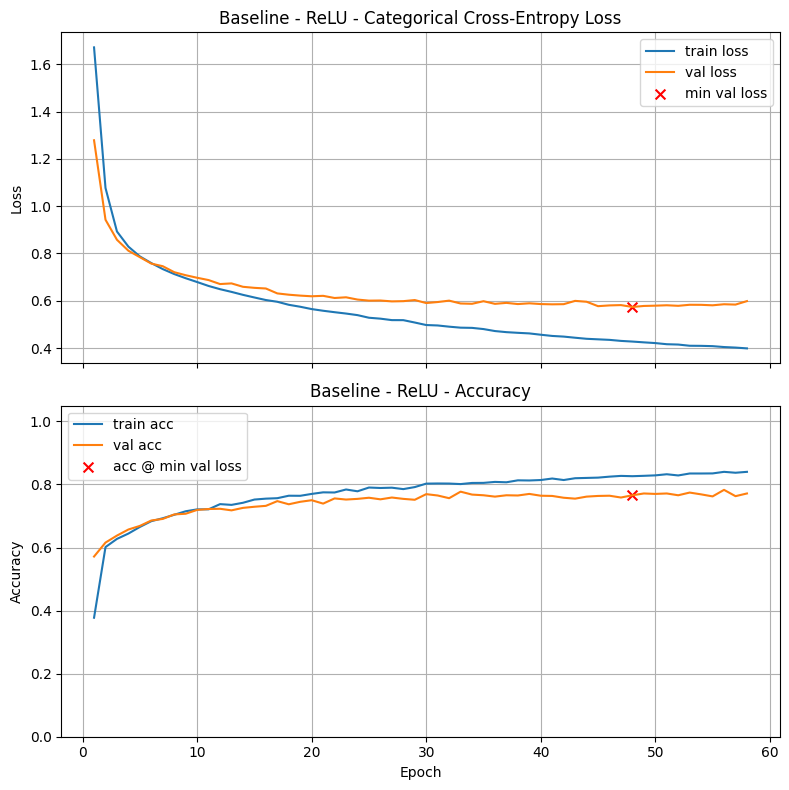

Final Training Loss:            0.3987
Final Training Accuracy:        0.8400
Final Validation Loss:          0.5986
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5739 (Epoch 48)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6200
Test Accuracy: 0.7443

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:09
Training Sigmoid model...

Baseline - Sigmoid



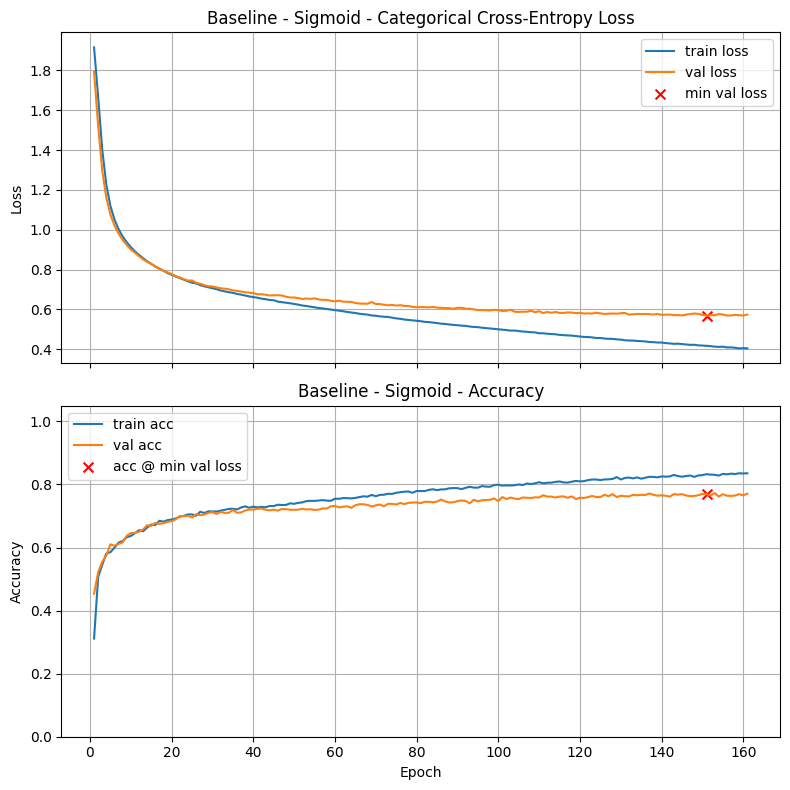

Final Training Loss:            0.4047
Final Training Accuracy:        0.8355
Final Validation Loss:          0.5742
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5689 (Epoch 151)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.5805
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:25
Training Tanh model...

Baseline - Tanh



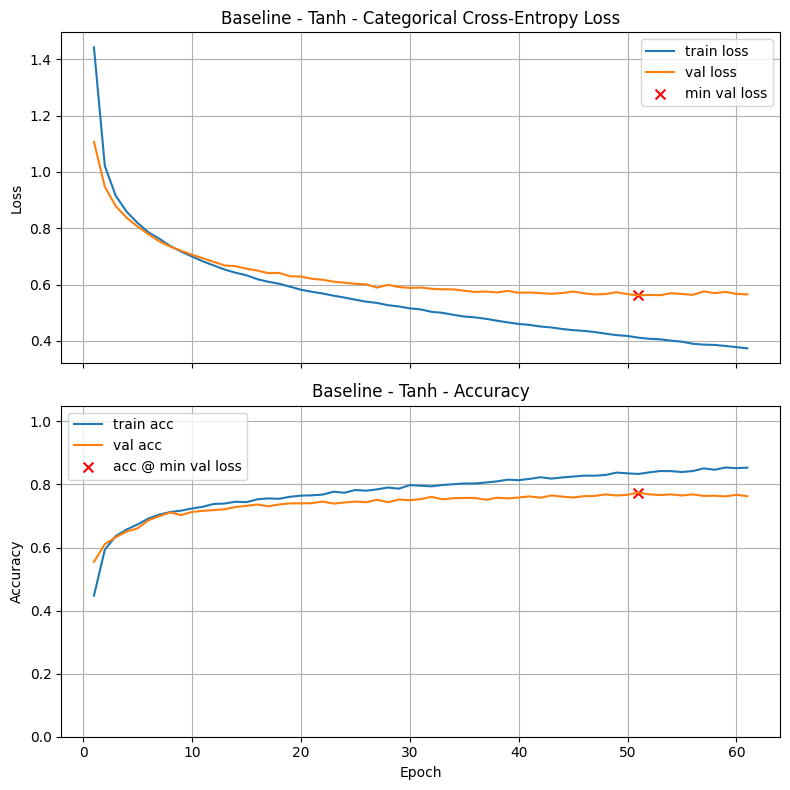

Final Training Loss:            0.3737
Final Training Accuracy:        0.8533
Final Validation Loss:          0.5655
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5623 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7743

Test Loss: 0.5946
Test Accuracy: 0.7529

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:10

PROBLEM 1 RESULTS: Activation Function Comparison
Baseline - Tanh                         	0.7743
Baseline - Sigmoid                      	0.7693
Baseline - ReLU                         	0.7657


In [55]:
# Your code here. Add as many cells as you need. 

#ReLU activation function
print("Training ReLU model...")
baseline_layers_relu = [(64, 'relu', 0.0, 0.0), (32, 'relu', 0.0, 0.0)]
model_baseline_relu = build_model(54, baseline_layers_relu, 7)
train_and_test(model_baseline_relu, title="Baseline - ReLU")

#Sigmoid activation function  
print("Training Sigmoid model...")
baseline_layers_sigmoid = [(64, 'sigmoid', 0.0, 0.0), (32, 'sigmoid', 0.0, 0.0)]
model_baseline_sigmoid = build_model(54, baseline_layers_sigmoid, 7)
train_and_test(model_baseline_sigmoid, title="Baseline - Sigmoid")

#Tanh activation function
print("Training Tanh model...")
baseline_layers_tanh = [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)]
model_baseline_tanh = build_model(54, baseline_layers_tanh, 7)
train_and_test(model_baseline_tanh, title="Baseline - Tanh")

print("\n" + "="*50)
print("PROBLEM 1 RESULTS: Activation Function Comparison")
print("="*50)
print_results()

### Graded Questions

In [60]:
# Set a1a to the activation function which provided the best validation accuracy at the epoch of minimum validation loss

a1a = 2             # Replace with integer 0 (relu), 1 (sigmoid), or 2 (tanh)

In [61]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a}') 


a1a = 2


In [62]:
# Set a1b to the validation accuracy found by this best activation function

a1b = 0.7743             # Replace 0.0 with your answer

In [63]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1b = {a1b:.4f}') 

a1b = 0.7743


### Problem Two: Finding the Right Learning Rate

In this problem, you will continue working with the **baseline model** and determine which learning rate produces the best performance. As before, the model you evaluate should be the one saved by **early stopping** — the epoch where validation loss is minimized.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function identified in Problem One**.

* Train and evaluate this model using each of the following learning rates:

  ```
      [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
  ```

* Identify which learning rate produces the **best validation accuracy** at the epoch of **minimum validation loss**, within a maximum of **500 epochs**.

* Answer the graded questions.


**Note: Smaller learning rates will generally take more epochs to reach the optimal point, so some of these will not engage early stopping, but run the full 500 epochs.**



Training with learning rate: 0.001

LR 1e-03



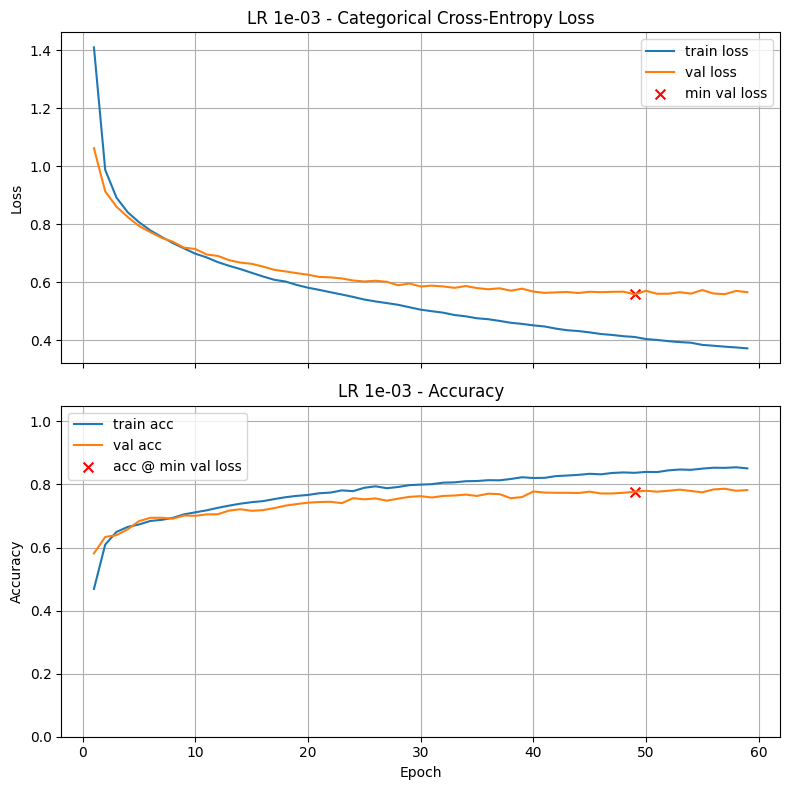

Final Training Loss:            0.3714
Final Training Accuracy:        0.8510
Final Validation Loss:          0.5654
Final Validation Accuracy:      0.7821
Minimum Validation Loss:        0.5578 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7771

Test Loss: 0.5632
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:10

Training with learning rate: 0.0005

LR 5e-04



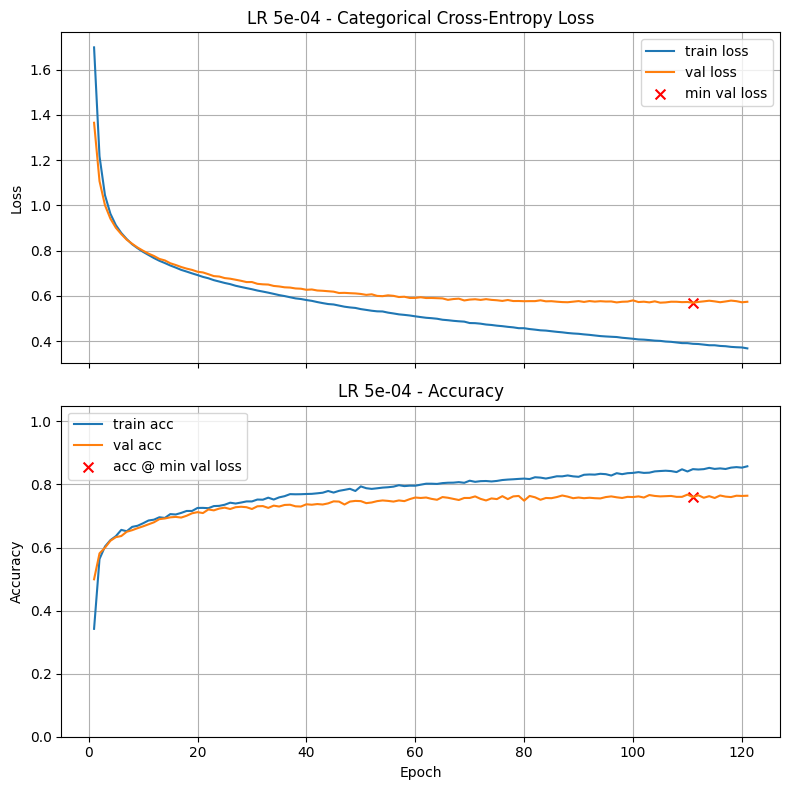

Final Training Loss:            0.3677
Final Training Accuracy:        0.8576
Final Validation Loss:          0.5737
Final Validation Accuracy:      0.7643
Minimum Validation Loss:        0.5695 (Epoch 111)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.5696
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:19

Training with learning rate: 0.0001

LR 1e-04



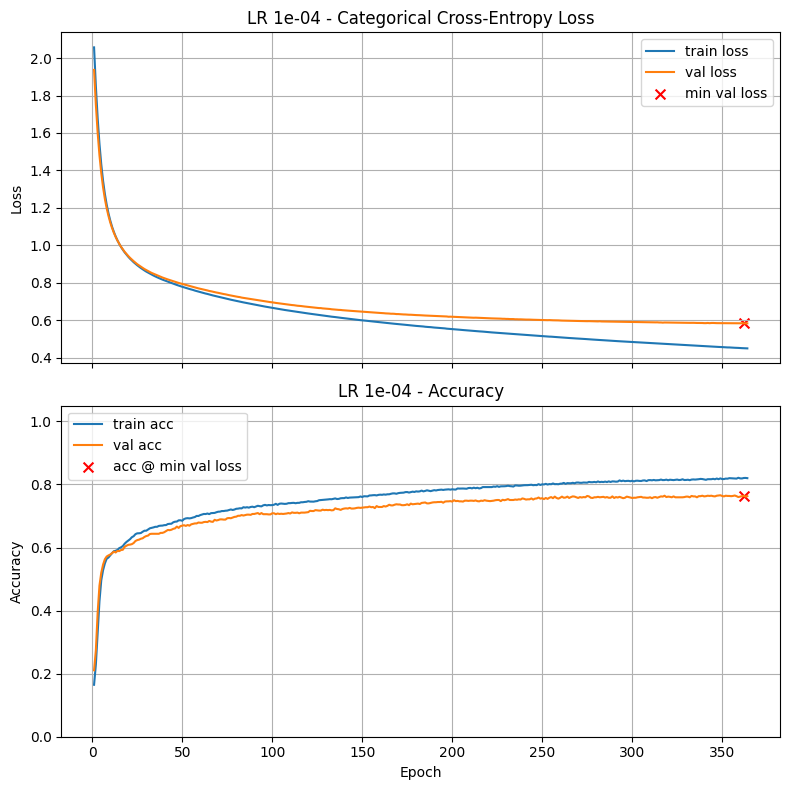

Final Training Loss:            0.4489
Final Training Accuracy:        0.8200
Final Validation Loss:          0.5826
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5825 (Epoch 362)
Validation Accuracy @ Min Loss: 0.7643

Test Loss: 0.5939
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:55

Training with learning rate: 5e-05

LR 5e-05



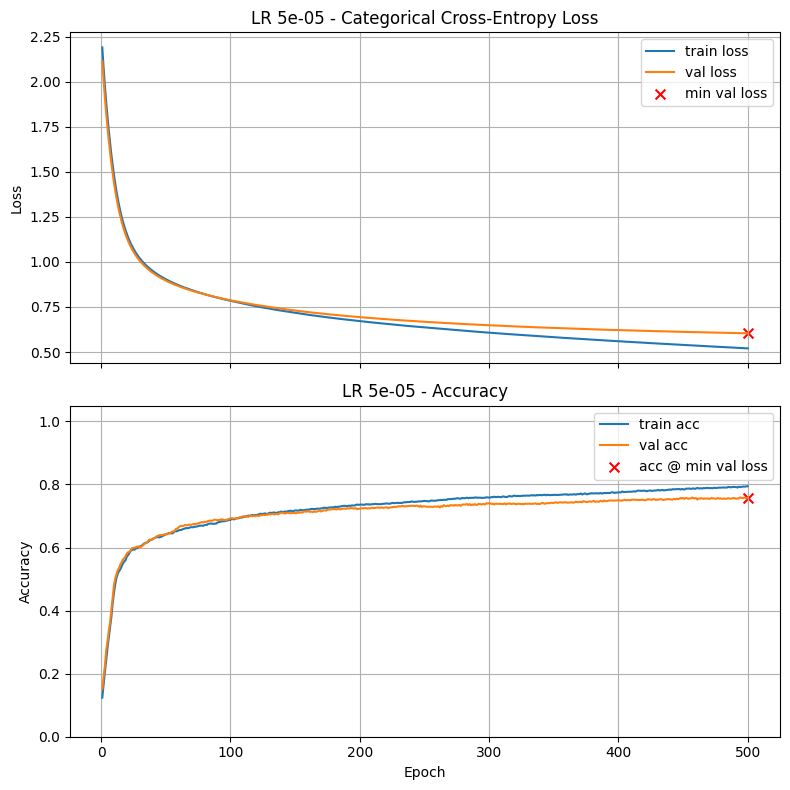

Final Training Loss:            0.5201
Final Training Accuracy:        0.7943
Final Validation Loss:          0.6038
Final Validation Accuracy:      0.7579
Minimum Validation Loss:        0.6038 (Epoch 500)
Validation Accuracy @ Min Loss: 0.7579

Test Loss: 0.6256
Test Accuracy: 0.7421

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:01:16

Training with learning rate: 1e-05

LR 1e-05



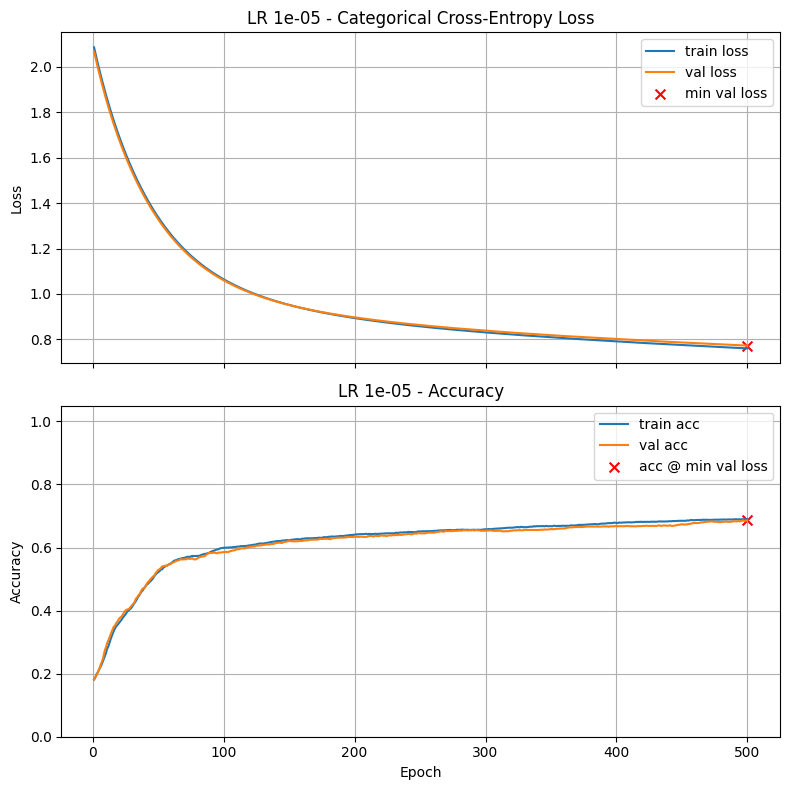

Final Training Loss:            0.7605
Final Training Accuracy:        0.6900
Final Validation Loss:          0.7728
Final Validation Accuracy:      0.6857
Minimum Validation Loss:        0.7728 (Epoch 500)
Validation Accuracy @ Min Loss: 0.6857

Test Loss: 0.7901
Test Accuracy: 0.6886

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:01:15

PROBLEM 2 RESULTS: Learning Rate Comparison
LR 1e-03                                	0.7771
Baseline - Tanh                         	0.7743
Baseline - Sigmoid                      	0.7693
Baseline - ReLU                         	0.7657
LR 1e-04                                	0.7643
LR 5e-04                                	0.7600
LR 5e-05                                	0.7579
LR 1e-05                                	0.6857


In [64]:
# Your code here. Add as many cells as you need. 

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")
    baseline_layers = [(64, 'tanh', 0.0, 0.0), (32, 'tanh', 0.0, 0.0)]
    model = build_model(54, baseline_layers, 7)
    train_and_test(model, lr_schedule=lr, title=f"LR {lr:.0e}")

print("\n" + "="*50)
print("PROBLEM 2 RESULTS: Learning Rate Comparison")
print("="*50)
print_results()

#### Graded Questions

In [65]:
# Set a2a to the learning rate which provided the best validation accuracy at the epoch of minimum validation loss

a2a = 0.001           # Replace 0.0 with your answer

In [66]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a:.6f}') 

a2a = 0.001000


In [67]:
# Set a2b to the validation accuracy found by this best learning rate

a2b = 0.7771             # Replace 0.0 with your answer

In [68]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7771


### Problem Three: Dropout

In this problem, you will explore how **dropout** can help prevent overfitting in neural networks. There are no absolute rules, but some useful hueristics are:

* Dropout typically works best in **later dense layers** (e.g., the second hidden layer of width 32) in the range **0.3–0.5**.
* If applied to **earlier layers** (e.g., the first hidden layer), dropout should be smaller, typically **0.0–0.2** (where 0.0 means no dropout).

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate dropout in the ranges suggested, using increments of **0.1**.
* Identify which dropout configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Training with dropout: Layer1=0.0, Layer2=0.0

Dropout (0.0, 0.0)



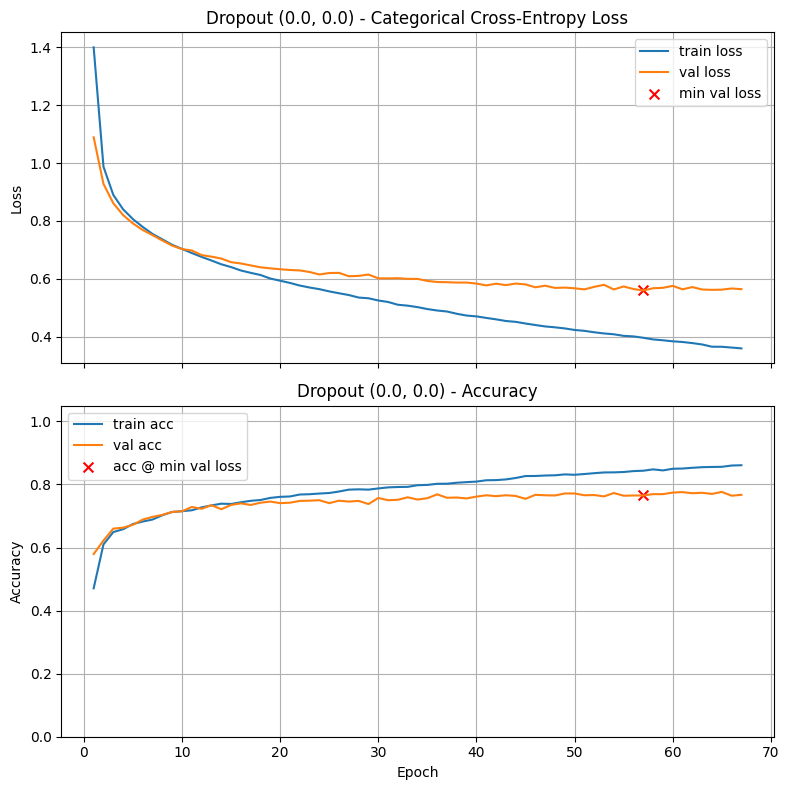

Final Training Loss:            0.3590
Final Training Accuracy:        0.8610
Final Validation Loss:          0.5638
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5593 (Epoch 57)
Validation Accuracy @ Min Loss: 0.7650

Test Loss: 0.5760
Test Accuracy: 0.7621

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:12

Training with dropout: Layer1=0.0, Layer2=0.3

Dropout (0.0, 0.3)



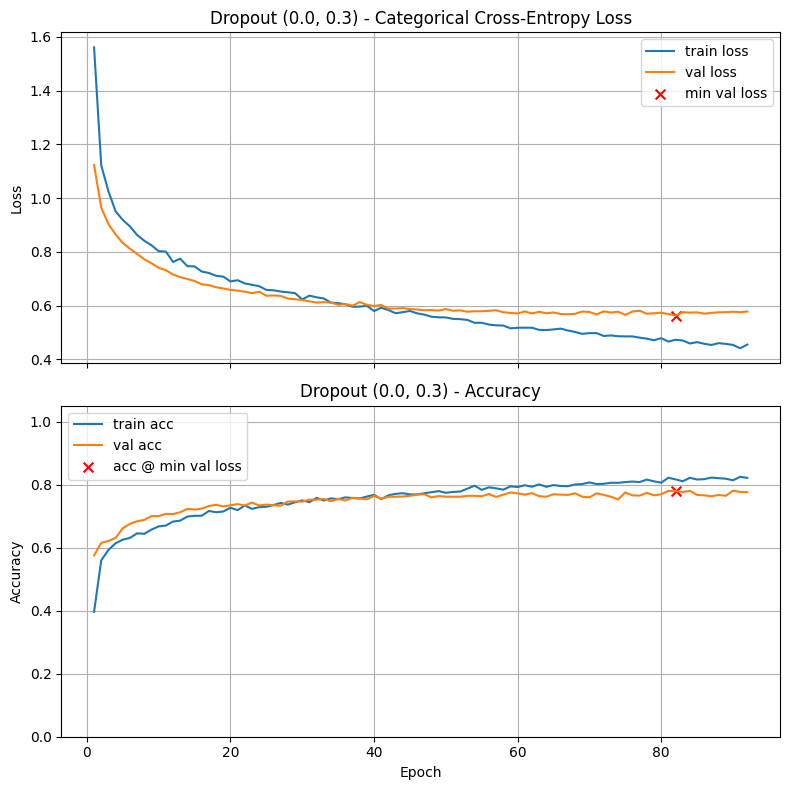

Final Training Loss:            0.4548
Final Training Accuracy:        0.8212
Final Validation Loss:          0.5779
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5630 (Epoch 82)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.5838
Test Accuracy: 0.7579

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:16

Training with dropout: Layer1=0.0, Layer2=0.4

Dropout (0.0, 0.4)



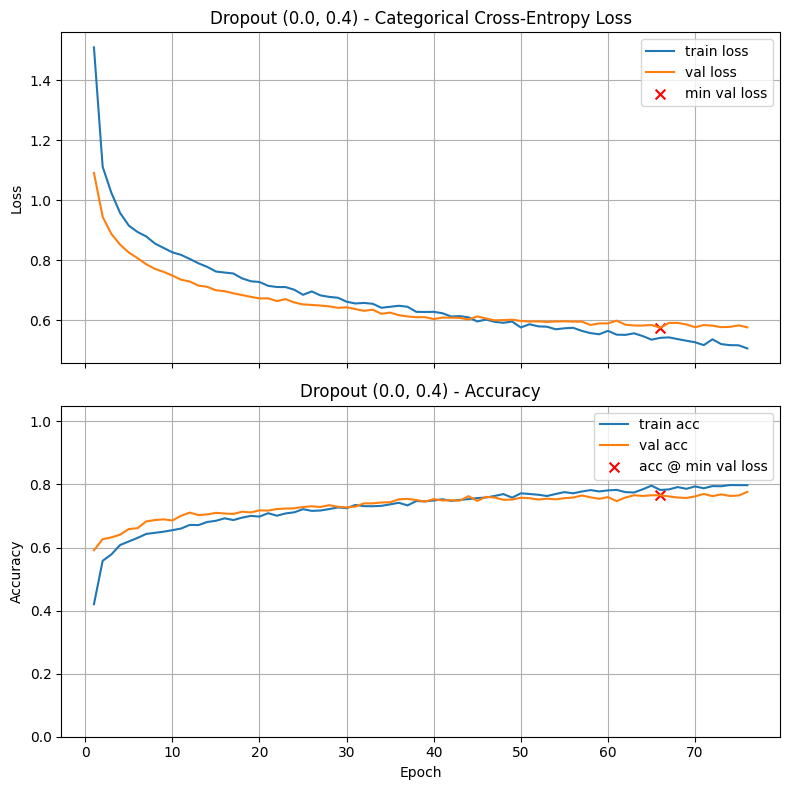

Final Training Loss:            0.5059
Final Training Accuracy:        0.7976
Final Validation Loss:          0.5761
Final Validation Accuracy:      0.7764
Minimum Validation Loss:        0.5748 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7657

Test Loss: 0.6157
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:13

Training with dropout: Layer1=0.0, Layer2=0.5

Dropout (0.0, 0.5)



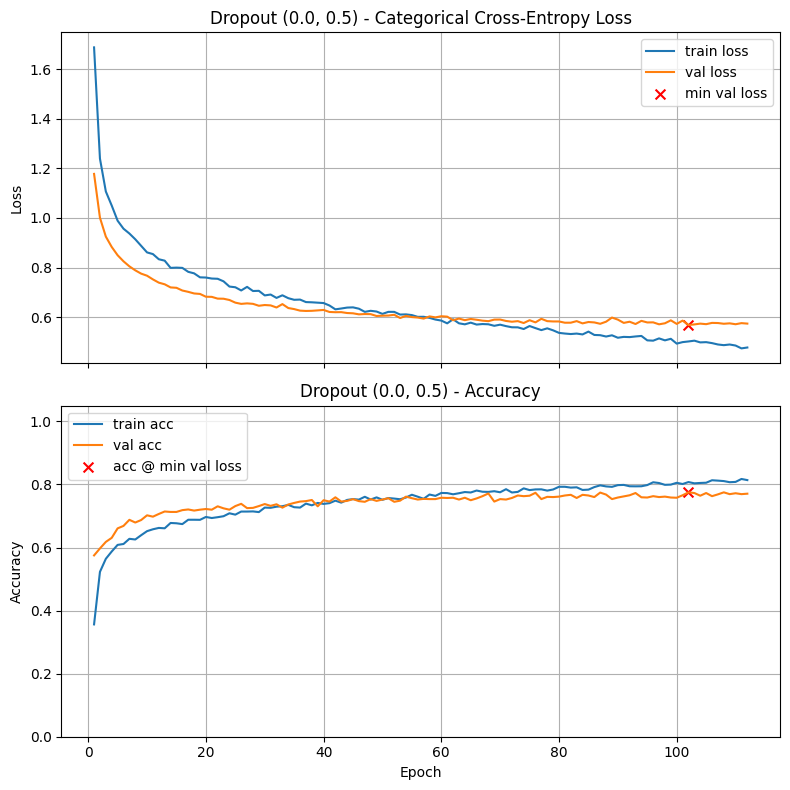

Final Training Loss:            0.4773
Final Training Accuracy:        0.8138
Final Validation Loss:          0.5737
Final Validation Accuracy:      0.7707
Minimum Validation Loss:        0.5680 (Epoch 102)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.6214
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:26

Training with dropout: Layer1=0.1, Layer2=0.0

Dropout (0.1, 0.0)



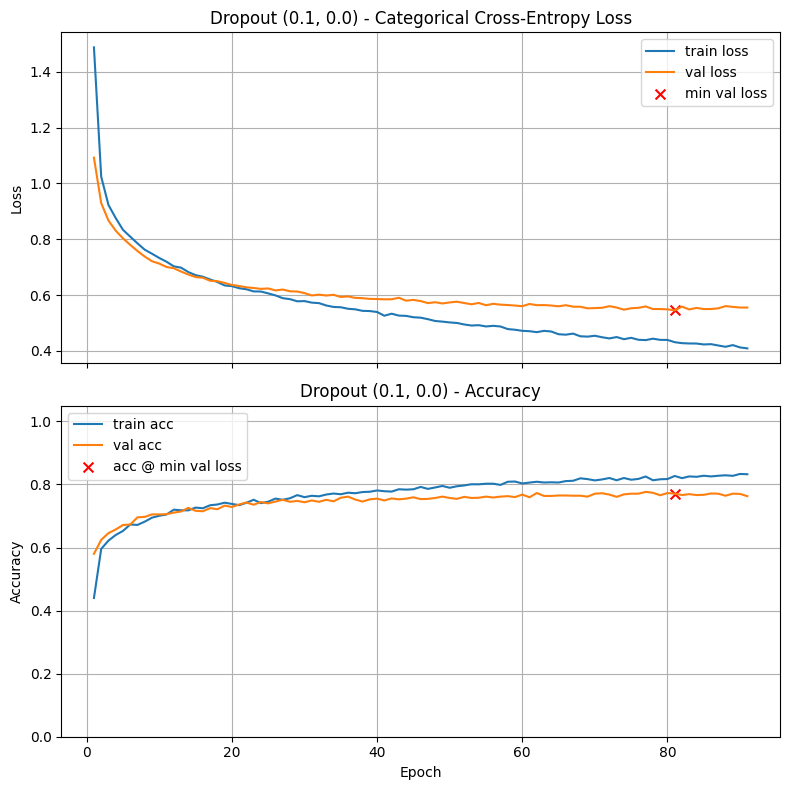

Final Training Loss:            0.4087
Final Training Accuracy:        0.8324
Final Validation Loss:          0.5552
Final Validation Accuracy:      0.7629
Minimum Validation Loss:        0.5450 (Epoch 81)
Validation Accuracy @ Min Loss: 0.7707

Test Loss: 0.5583
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:22

Training with dropout: Layer1=0.1, Layer2=0.3

Dropout (0.1, 0.3)



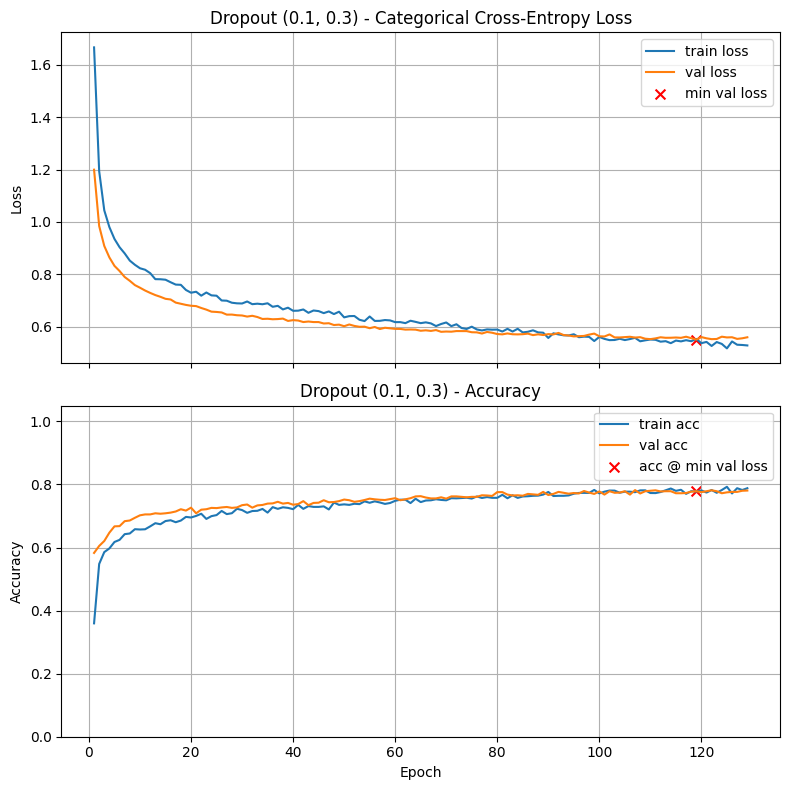

Final Training Loss:            0.5284
Final Training Accuracy:        0.7881
Final Validation Loss:          0.5596
Final Validation Accuracy:      0.7807
Minimum Validation Loss:        0.5507 (Epoch 119)
Validation Accuracy @ Min Loss: 0.7786

Test Loss: 0.5835
Test Accuracy: 0.7693

Validation-Test Gap (accuracy): 0.009286

Execution Time: 00:00:22

Training with dropout: Layer1=0.1, Layer2=0.4

Dropout (0.1, 0.4)



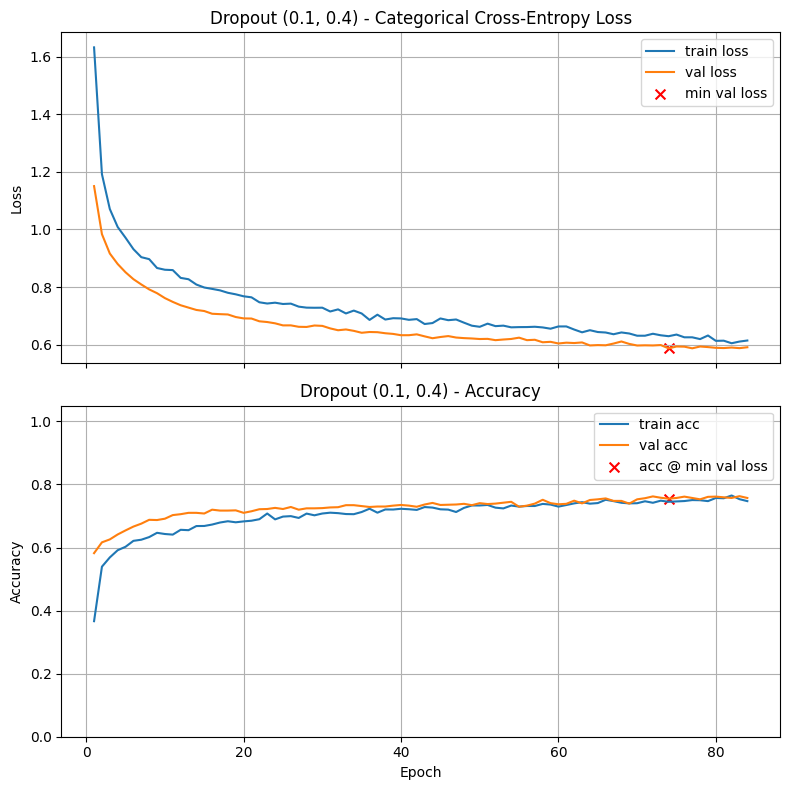

Final Training Loss:            0.6142
Final Training Accuracy:        0.7471
Final Validation Loss:          0.5908
Final Validation Accuracy:      0.7571
Minimum Validation Loss:        0.5869 (Epoch 74)
Validation Accuracy @ Min Loss: 0.7550

Test Loss: 0.6283
Test Accuracy: 0.7336

Validation-Test Gap (accuracy): 0.021429

Execution Time: 00:00:14

Training with dropout: Layer1=0.1, Layer2=0.5

Dropout (0.1, 0.5)



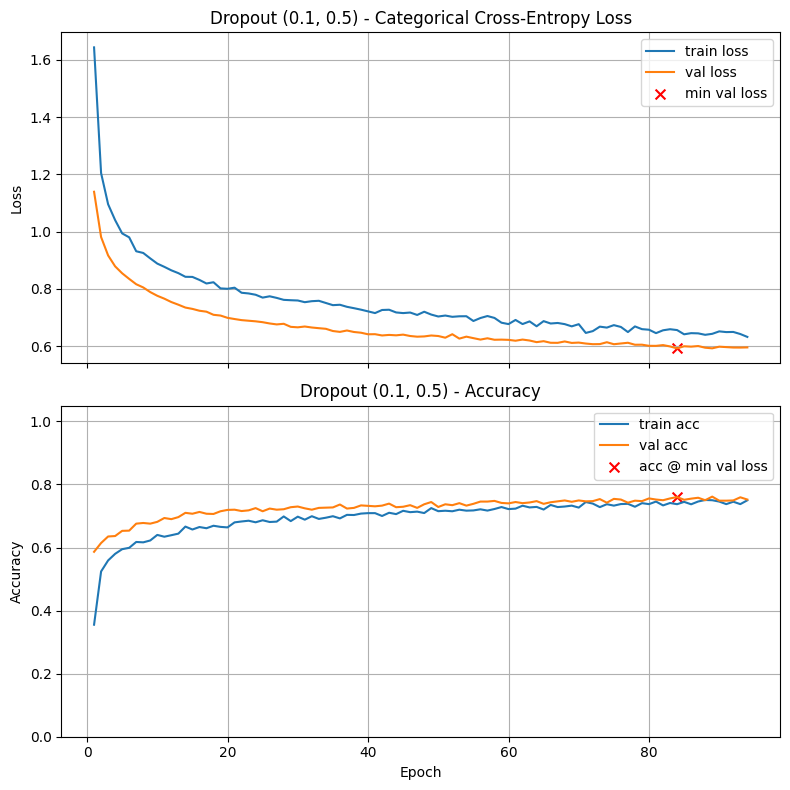

Final Training Loss:            0.6320
Final Training Accuracy:        0.7498
Final Validation Loss:          0.5953
Final Validation Accuracy:      0.7521
Minimum Validation Loss:        0.5919 (Epoch 84)
Validation Accuracy @ Min Loss: 0.7600

Test Loss: 0.6222
Test Accuracy: 0.7536

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:16

Training with dropout: Layer1=0.2, Layer2=0.0

Dropout (0.2, 0.0)



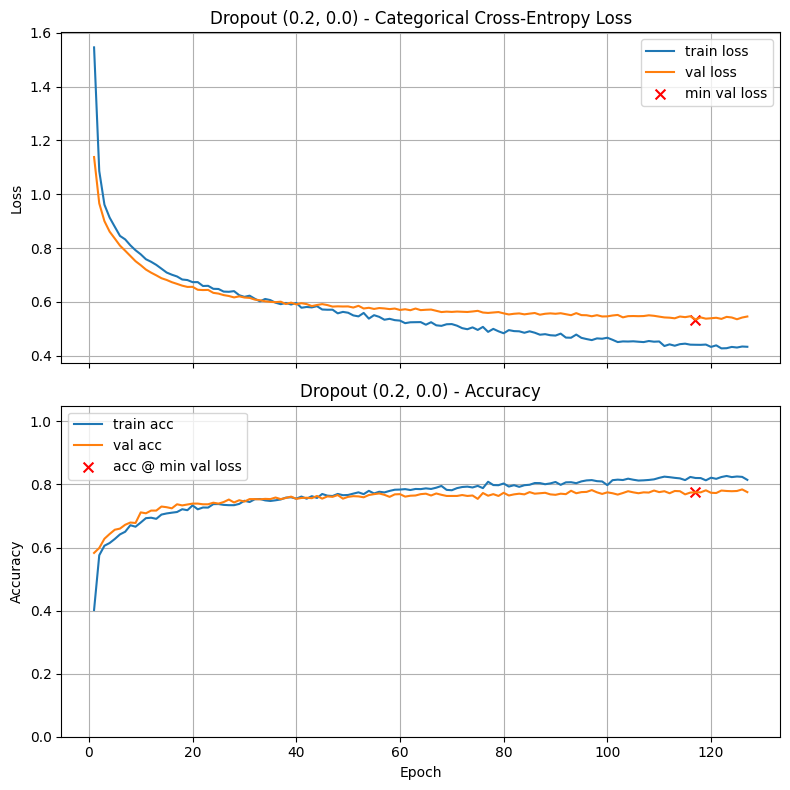

Final Training Loss:            0.4334
Final Training Accuracy:        0.8145
Final Validation Loss:          0.5459
Final Validation Accuracy:      0.7757
Minimum Validation Loss:        0.5347 (Epoch 117)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.5792
Test Accuracy: 0.7679

Validation-Test Gap (accuracy): 0.007143

Execution Time: 00:00:21

Training with dropout: Layer1=0.2, Layer2=0.3

Dropout (0.2, 0.3)



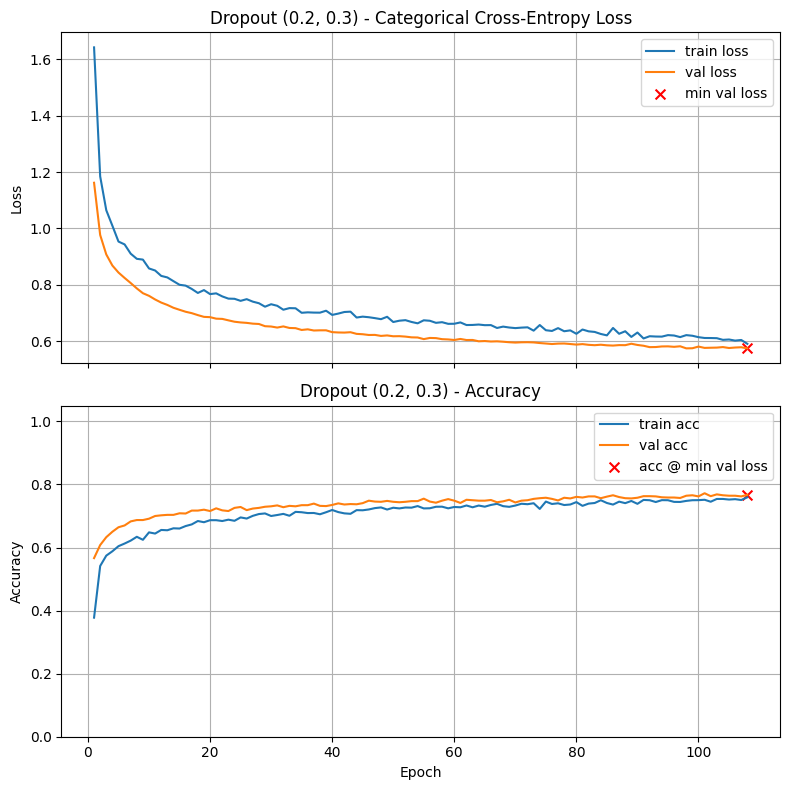

Final Training Loss:            0.5903
Final Training Accuracy:        0.7593
Final Validation Loss:          0.5740
Final Validation Accuracy:      0.7671
Minimum Validation Loss:        0.5740 (Epoch 108)
Validation Accuracy @ Min Loss: 0.7671

Test Loss: 0.6046
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.002857

Execution Time: 00:00:18

Training with dropout: Layer1=0.2, Layer2=0.4

Dropout (0.2, 0.4)



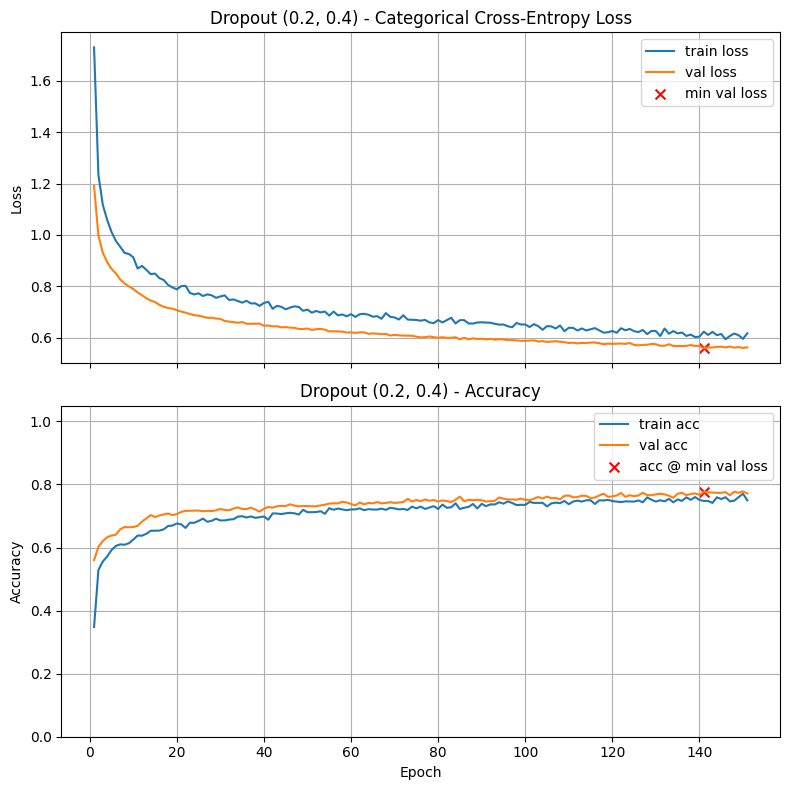

Final Training Loss:            0.6182
Final Training Accuracy:        0.7495
Final Validation Loss:          0.5633
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5594 (Epoch 141)
Validation Accuracy @ Min Loss: 0.7757

Test Loss: 0.5975
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.020000

Execution Time: 00:00:25

Training with dropout: Layer1=0.2, Layer2=0.5

Dropout (0.2, 0.5)



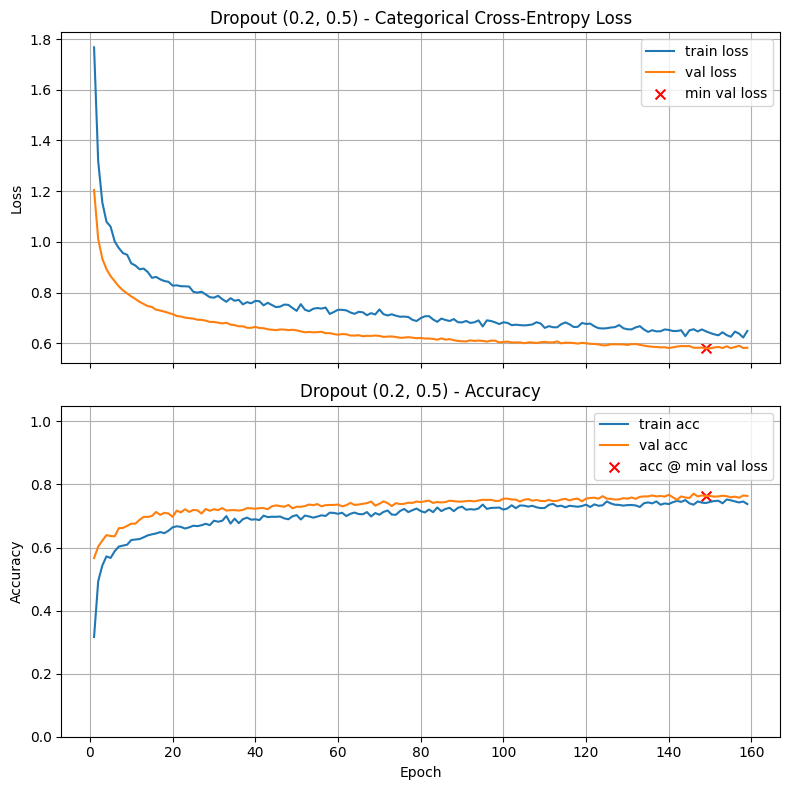

Final Training Loss:            0.6484
Final Training Accuracy:        0.7379
Final Validation Loss:          0.5823
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.5797 (Epoch 149)
Validation Accuracy @ Min Loss: 0.7636

Test Loss: 0.6211
Test Accuracy: 0.7379

Validation-Test Gap (accuracy): 0.025714

Execution Time: 00:00:27

PROBLEM 3 RESULTS: Dropout Comparison
Dropout (0.0, 0.3)                      	0.7793
Dropout (0.1, 0.3)                      	0.7786
LR 1e-03                                	0.7771
Dropout (0.2, 0.4)                      	0.7757
Dropout (0.0, 0.5)                      	0.7750
Dropout (0.2, 0.0)                      	0.7750
Baseline - Tanh                         	0.7743
Dropout (0.1, 0.0)                      	0.7707
Baseline - Sigmoid                      	0.7693
Dropout (0.2, 0.3)                      	0.7671
Baseline - ReLU                         	0.7657
Dropout (0.0, 0.4)                      	0.7657
Dropout (0.0, 0.0)            

In [77]:
# Your code here. Add as many cells as you need. 

dropout_configs = [
    (0.0, 0.0),
    (0.0, 0.3),
    (0.0, 0.4),
    (0.0, 0.5),
    (0.1, 0.0),
    (0.1, 0.3),
    (0.1, 0.4),
    (0.1, 0.5),
    (0.2, 0.0),
    (0.2, 0.3),
    (0.2, 0.4),
    (0.2, 0.5),
]

for dropout1, dropout2 in dropout_configs:
    print(f"\nTraining with dropout: Layer1={dropout1}, Layer2={dropout2}")
    
    baseline_layers = [(64, 'tanh', 0.0, dropout1), (32, 'tanh', 0.0, dropout2)]
    model = build_model(54, baseline_layers, 7)
    
    title = f"Dropout ({dropout1}, {dropout2})"
    train_and_test(model, lr_schedule=0.001, title=title)

print("\n" + "="*50)
print("PROBLEM 3 RESULTS: Dropout Comparison")
print("="*50)
print_results()

In [87]:
# Set a3a to the pair (dropout_rate_64,dropout_rate_32) of dropout rates for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a3a = (0.0,0.3)             # Replace (0.0,0.0) with your answer

In [88]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a}') 

a3a = (0.0, 0.3)


In [89]:
# Set a3b to the validation accuracy found by this best pair of dropout rates

a3b = 0.7793             # Replace 0.0 with your answer

In [90]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7793


### Problem Four: L2 Regularization

In this problem, you will explore how **L2 regularization** (also called *weight decay*) can help prevent overfitting in neural networks. There are no absolute rules, but some useful heuristics are:

* Start simple by using the **same λ in both hidden layers**, with values:

  ```
      1e-4, 1e-3, 1e-2
  ```

* If validation results suggest underfitting in the first layer or persistent overfitting in the later one, then try adjusting per layer, for example:

  * First hidden layer: λ = 1e-4
  * Second hidden layer: λ = 1e-3

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**, but **without dropout**.
* Investigate at least the four cases suggested (three with the same λ and one with different λ values). You may also consider additional combinations.
* Identify which configuration produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.



Training with L2: Layer1=0.0, Layer2=0.0

L2 (0e+00, 0e+00)



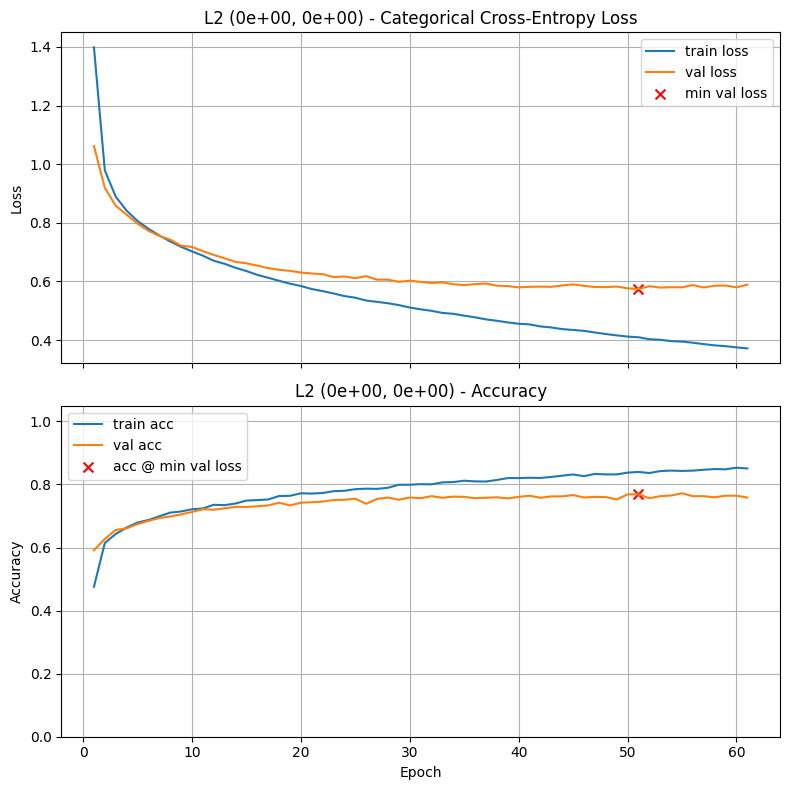

Final Training Loss:            0.3718
Final Training Accuracy:        0.8507
Final Validation Loss:          0.5890
Final Validation Accuracy:      0.7586
Minimum Validation Loss:        0.5742 (Epoch 51)
Validation Accuracy @ Min Loss: 0.7686

Test Loss: 0.5841
Test Accuracy: 0.7571

Validation-Test Gap (accuracy): 0.011429

Execution Time: 00:00:12

Training with L2: Layer1=0.0001, Layer2=0.0001

L2 (1e-04, 1e-04)



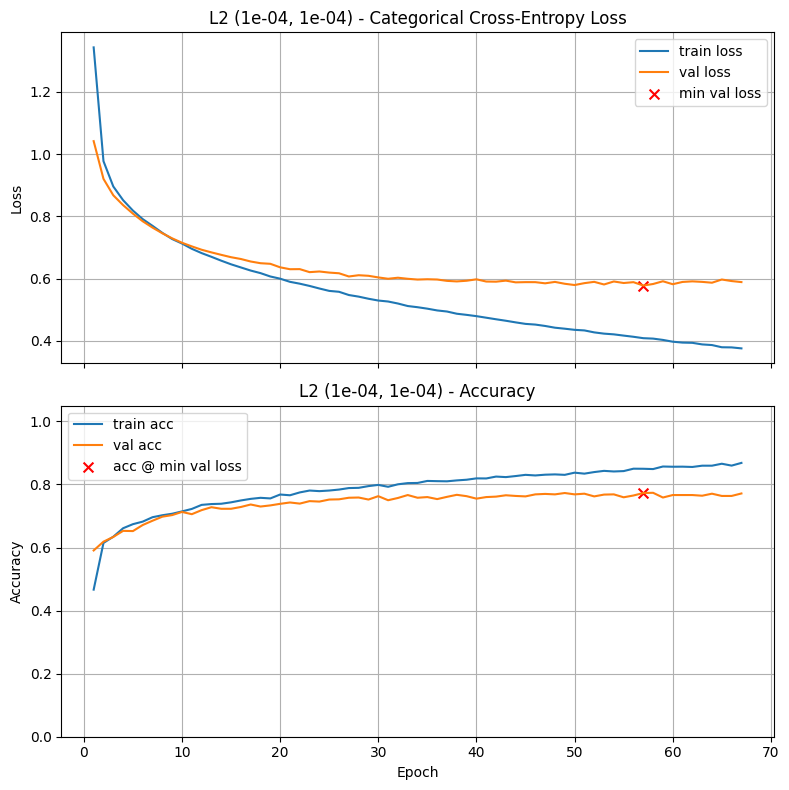

Final Training Loss:            0.3759
Final Training Accuracy:        0.8683
Final Validation Loss:          0.5890
Final Validation Accuracy:      0.7714
Minimum Validation Loss:        0.5778 (Epoch 57)
Validation Accuracy @ Min Loss: 0.7729

Test Loss: 0.5840
Test Accuracy: 0.7600

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:13

Training with L2: Layer1=0.001, Layer2=0.001

L2 (1e-03, 1e-03)



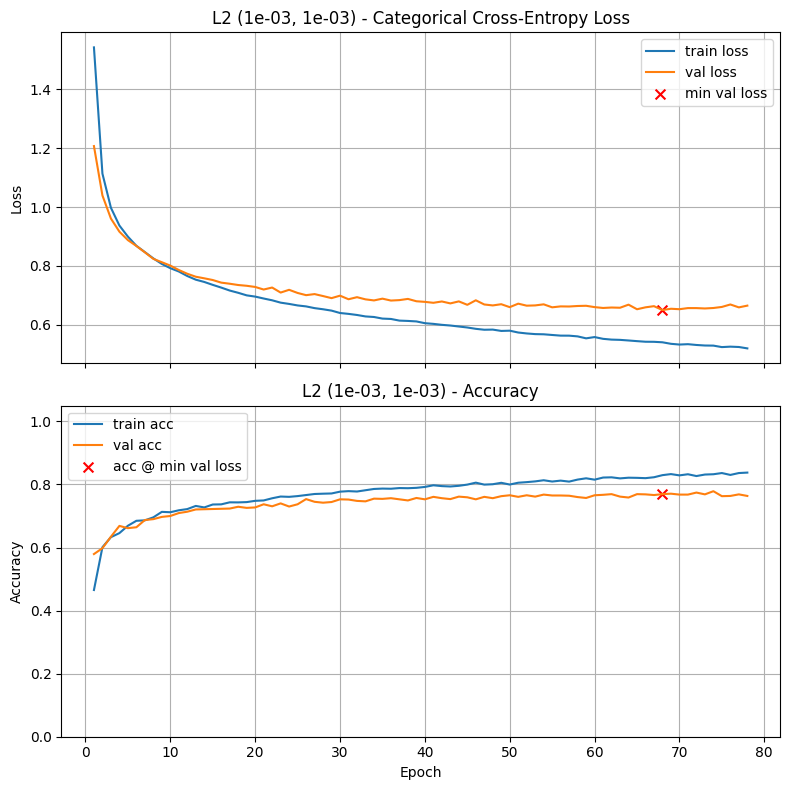

Final Training Loss:            0.5201
Final Training Accuracy:        0.8376
Final Validation Loss:          0.6652
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6502 (Epoch 68)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6698
Test Accuracy: 0.7614

Validation-Test Gap (accuracy): 0.007857

Execution Time: 00:00:14

Training with L2: Layer1=0.01, Layer2=0.01

L2 (1e-02, 1e-02)



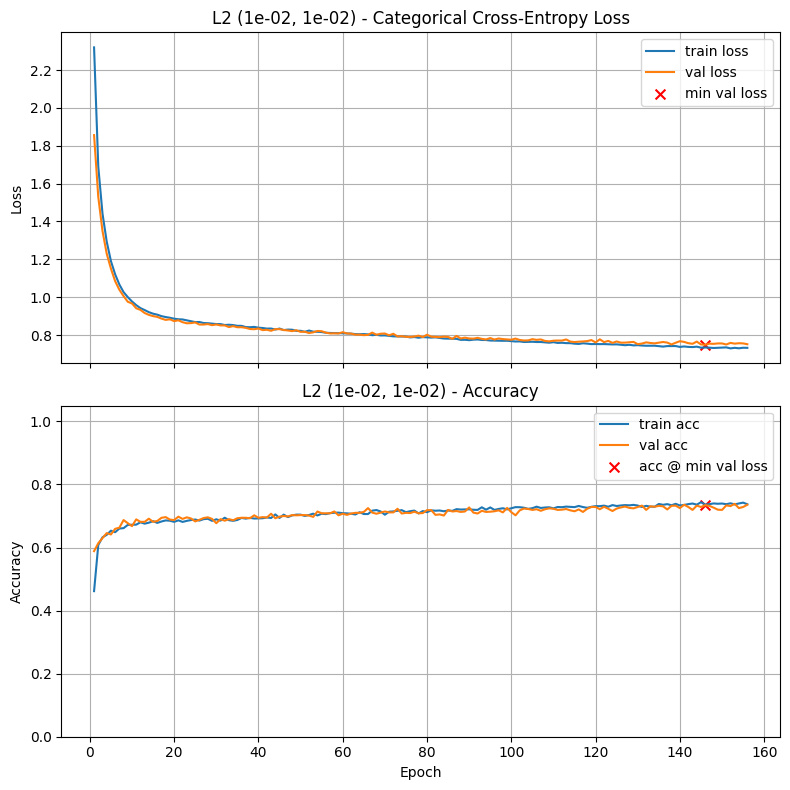

Final Training Loss:            0.7324
Final Training Accuracy:        0.7371
Final Validation Loss:          0.7515
Final Validation Accuracy:      0.7357
Minimum Validation Loss:        0.7491 (Epoch 146)
Validation Accuracy @ Min Loss: 0.7343

Test Loss: 0.7740
Test Accuracy: 0.7243

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:27

Training with L2: Layer1=0.0001, Layer2=0.001

L2 (1e-04, 1e-03)



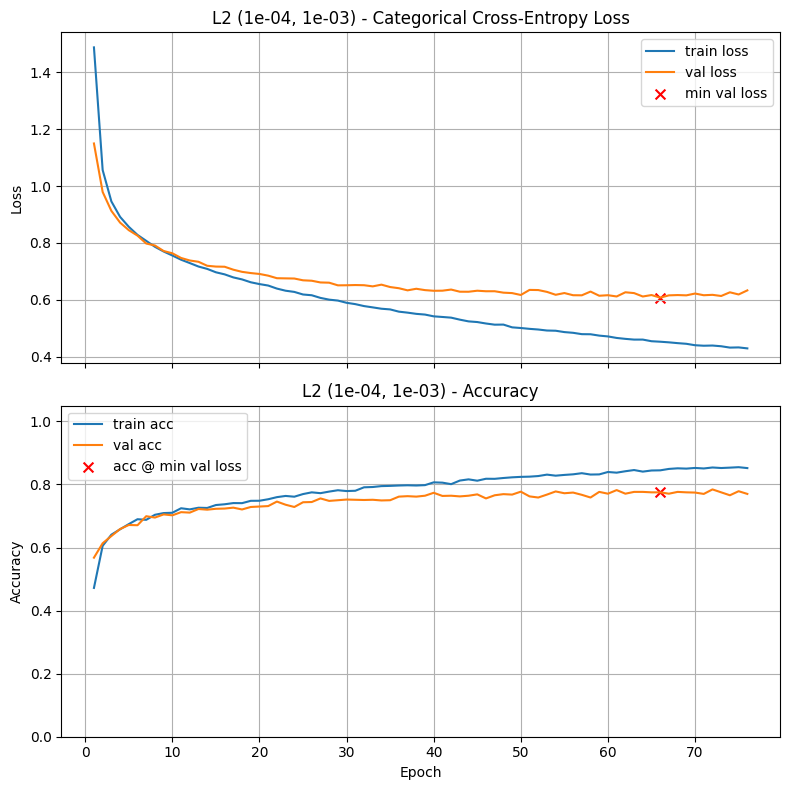

Final Training Loss:            0.4294
Final Training Accuracy:        0.8519
Final Validation Loss:          0.6334
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.6079 (Epoch 66)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.6274
Test Accuracy: 0.7700

Validation-Test Gap (accuracy): 0.005000

Execution Time: 00:00:14

Training with L2: Layer1=0.001, Layer2=0.01

L2 (1e-03, 1e-02)



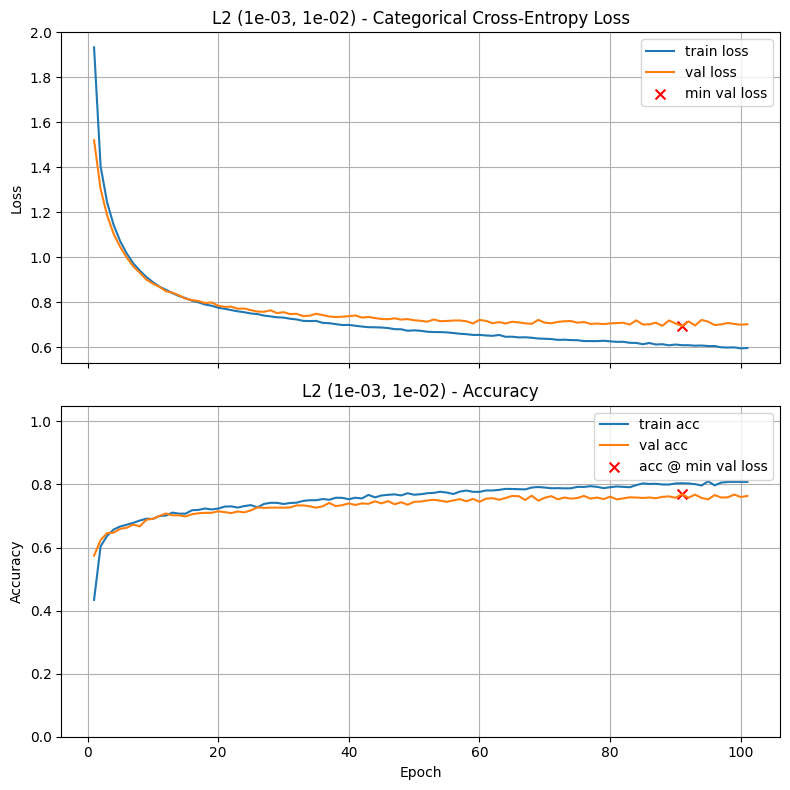

Final Training Loss:            0.5972
Final Training Accuracy:        0.8081
Final Validation Loss:          0.7031
Final Validation Accuracy:      0.7636
Minimum Validation Loss:        0.6955 (Epoch 91)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.7096
Test Accuracy: 0.7593

Validation-Test Gap (accuracy): 0.010000

Execution Time: 00:00:18

PROBLEM 4 RESULTS: L2 Regularization Comparison
L2 (1e-04, 1e-03)                       	0.7750
L2 (1e-04, 1e-04)                       	0.7729
L2 (1e-03, 1e-03)                       	0.7693
L2 (1e-03, 1e-02)                       	0.7693
L2 (0e+00, 0e+00)                       	0.7686
L2 (1e-02, 1e-02)                       	0.7343


In [16]:
# Your code here. Add as many cells as you need. 

l2_configs = [
    (0.0, 0.0),
    (1e-4, 1e-4),
    (1e-3, 1e-3),  
    (1e-2, 1e-2),
    (1e-4, 1e-3),
    (1e-3, 1e-2),
]

for l2_1, l2_2 in l2_configs:
    print(f"\nTraining with L2: Layer1={l2_1}, Layer2={l2_2}")
    
    baseline_layers = [(64, 'tanh', l2_1, 0.0), (32, 'tanh', l2_2, 0.0)]
    model = build_model(54, baseline_layers, 7)
    
    title = f"L2 ({l2_1:.0e}, {l2_2:.0e})"
    train_and_test(model, lr_schedule=0.001, title=title)

print("\n" + "="*50)
print("PROBLEM 4 RESULTS: L2 Regularization Comparison")
print("="*50)
print_results()

In [17]:
# Set a4a to the pair (L2_lambda_64,L2_lambda_32) of the L2 lambdas for the two hidden layers which provided the best 
# validation accuracy at the epoch of minimum validation loss

a4a = (0.0001,0.001)             # Replace (0.0,0.0) with your answer

In [18]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a}') 

a4a = (0.0001, 0.001)


In [23]:
# Set a4b to the validation accuracy found by this best pair of lambdas

a4b = 0.7750             # Replace 0.0 with your answer

In [24]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.7750


### Problem Five: Combining Dropout with L2 Regularization

In this problem, you will explore how **dropout** and **L2 regularization** can work together to prevent overfitting. These two methods complement each other, but must be balanced carefully. A useful rule of thumb is:

* If dropout is **high**, use a **smaller λ**.
* If dropout is **low**, you can afford a **larger λ**.

**Steps to follow:**

* Build and train the **baseline model** using the **activation function from Problem One** and the **learning rate from Problem Two**.
* Investigate combinations of dropout and L2:

  * First, use the **dropout rate you identified in Problem Three** as a baseline.
  * Then, add L2 to both hidden layers with values:

    ```
        1e-4, 1e-3, 1e-2
    ```

    while keeping dropout fixed.
  * Finally, try **reducing dropout slightly** when L2 is added to see if performance improves.
  * [Optional] You may wish to investigate other combinations not covered here; for example, promising but not optimal choices of dropout rates may provide overall better performance when combines with L2 Regulari 
* Identify which combination produces the **best validation accuracy** at the epoch of **minimum validation loss**.
* Answer the graded questions.




Training with Dropout=(0.0, 0.3), L2=(0.0, 0.0)

Drop(0.0,0.3)+L2(0e+00,0e+00)



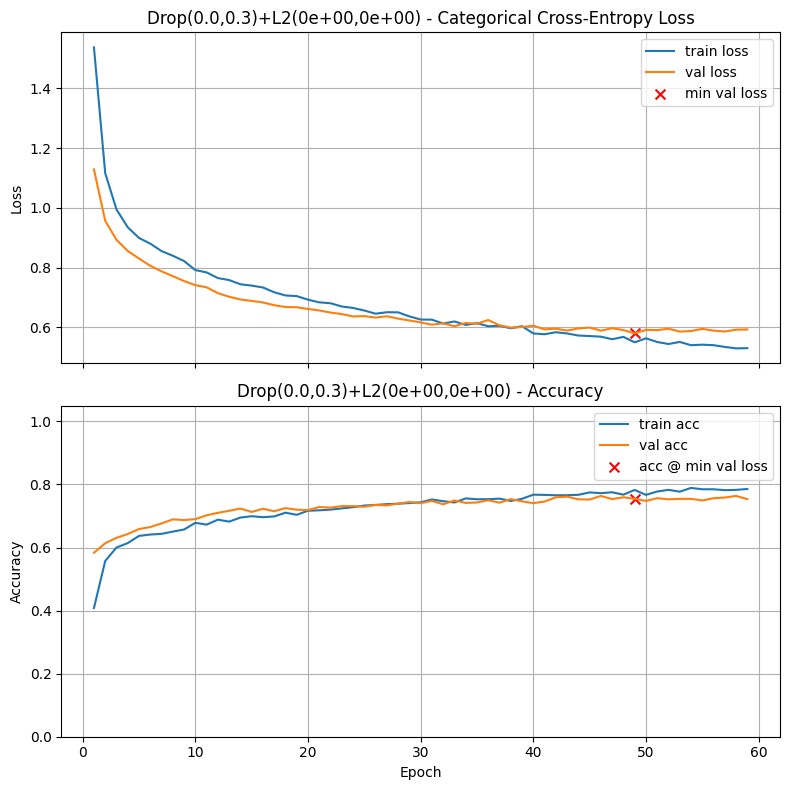

Final Training Loss:            0.5301
Final Training Accuracy:        0.7857
Final Validation Loss:          0.5927
Final Validation Accuracy:      0.7536
Minimum Validation Loss:        0.5798 (Epoch 49)
Validation Accuracy @ Min Loss: 0.7543

Test Loss: 0.6227
Test Accuracy: 0.7364

Validation-Test Gap (accuracy): 0.017857

Execution Time: 00:00:12

Training with Dropout=(0.0, 0.3), L2=(0.0001, 0.0001)

Drop(0.0,0.3)+L2(1e-04,1e-04)



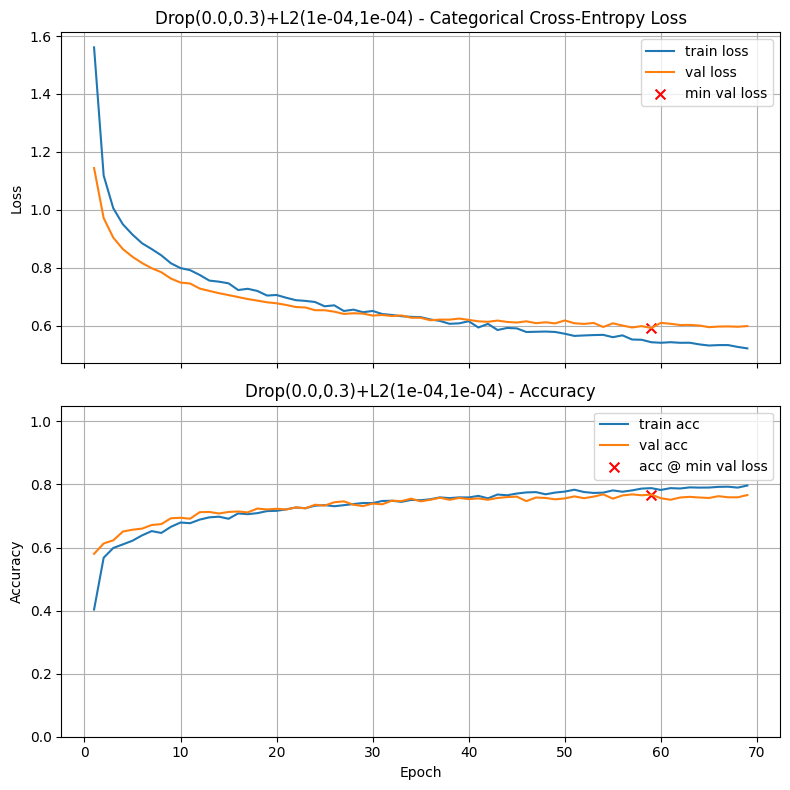

Final Training Loss:            0.5218
Final Training Accuracy:        0.7967
Final Validation Loss:          0.5987
Final Validation Accuracy:      0.7664
Minimum Validation Loss:        0.5920 (Epoch 59)
Validation Accuracy @ Min Loss: 0.7679

Test Loss: 0.6238
Test Accuracy: 0.7550

Validation-Test Gap (accuracy): 0.012857

Execution Time: 00:00:14

Training with Dropout=(0.0, 0.3), L2=(0.001, 0.001)

Drop(0.0,0.3)+L2(1e-03,1e-03)



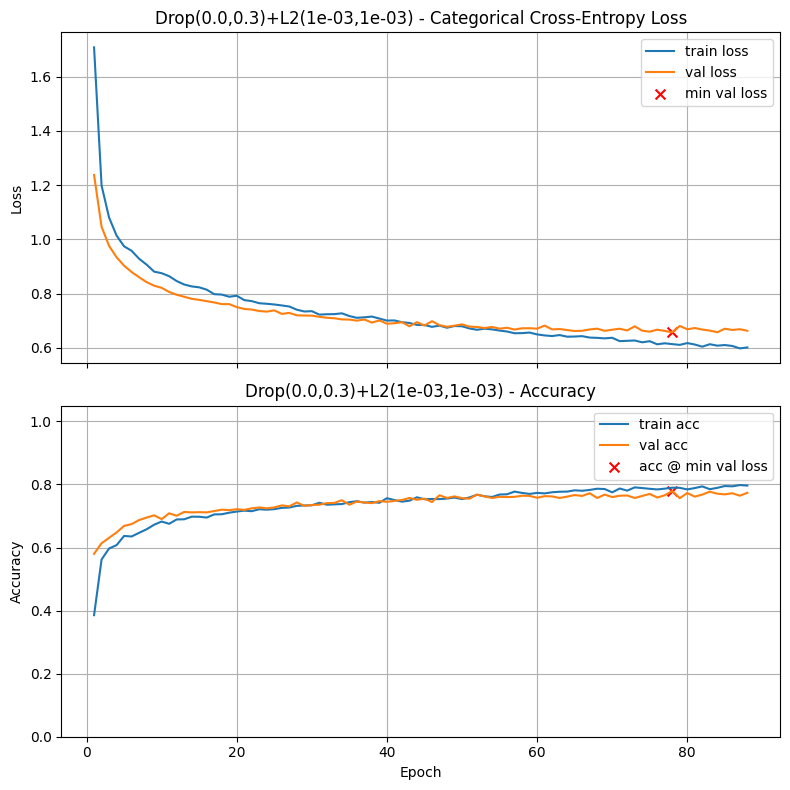

Final Training Loss:            0.6016
Final Training Accuracy:        0.7964
Final Validation Loss:          0.6631
Final Validation Accuracy:      0.7736
Minimum Validation Loss:        0.6571 (Epoch 78)
Validation Accuracy @ Min Loss: 0.7793

Test Loss: 0.6851
Test Accuracy: 0.7629

Validation-Test Gap (accuracy): 0.016429

Execution Time: 00:00:16

Training with Dropout=(0.0, 0.3), L2=(0.01, 0.01)

Drop(0.0,0.3)+L2(1e-02,1e-02)



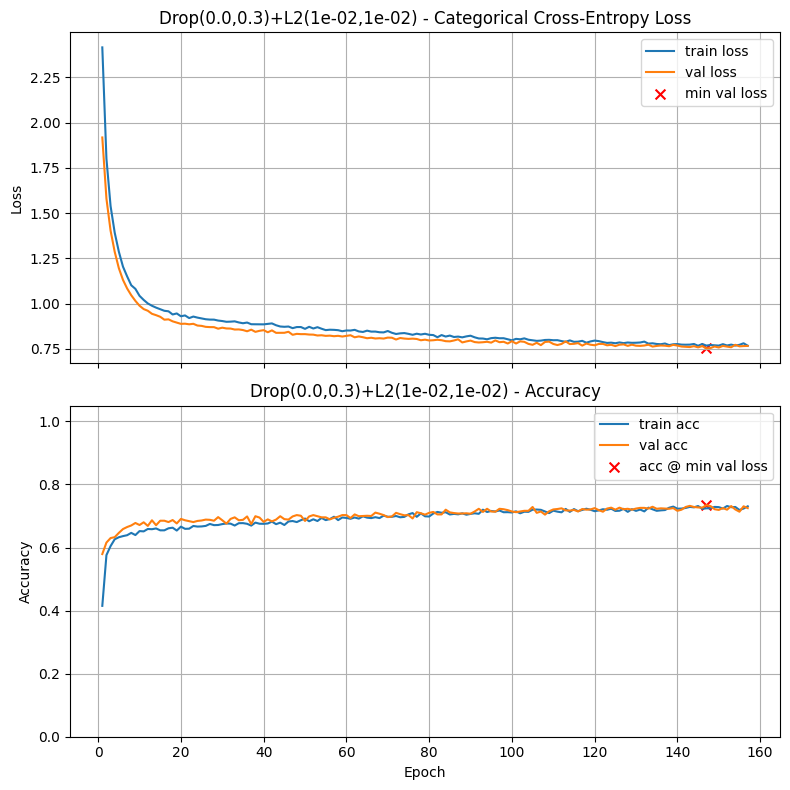

Final Training Loss:            0.7673
Final Training Accuracy:        0.7307
Final Validation Loss:          0.7662
Final Validation Accuracy:      0.7250
Minimum Validation Loss:        0.7526 (Epoch 147)
Validation Accuracy @ Min Loss: 0.7343

Test Loss: 0.7794
Test Accuracy: 0.7307

Validation-Test Gap (accuracy): 0.003571

Execution Time: 00:00:27

Training with Dropout=(0.0, 0.2), L2=(0.0001, 0.0001)

Drop(0.0,0.2)+L2(1e-04,1e-04)



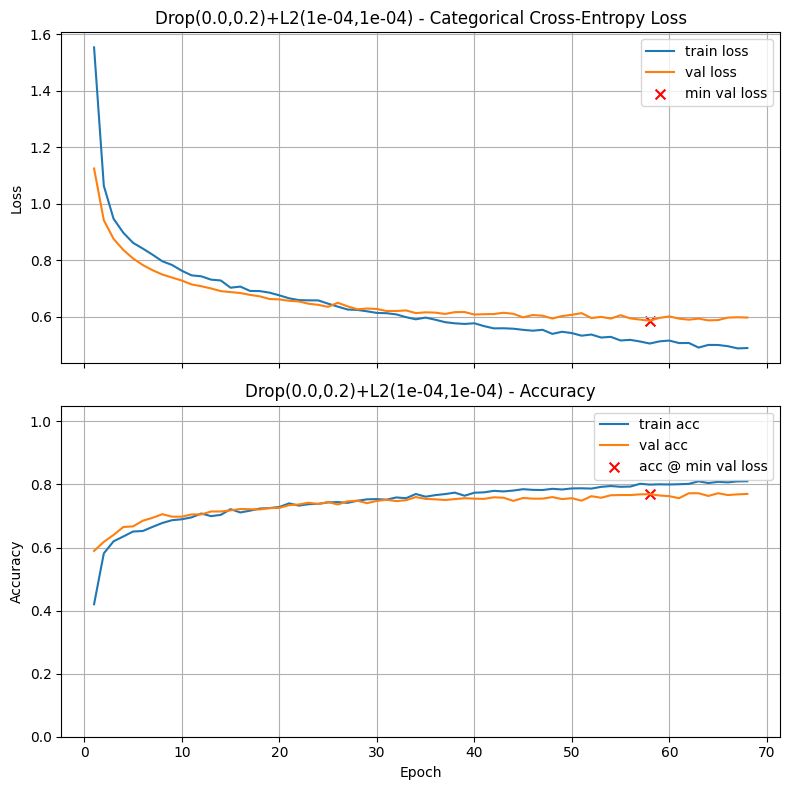

Final Training Loss:            0.4896
Final Training Accuracy:        0.8102
Final Validation Loss:          0.5974
Final Validation Accuracy:      0.7700
Minimum Validation Loss:        0.5862 (Epoch 58)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6172
Test Accuracy: 0.7586

Validation-Test Gap (accuracy): 0.010714

Execution Time: 00:00:13

Training with Dropout=(0.0, 0.2), L2=(0.001, 0.001)

Drop(0.0,0.2)+L2(1e-03,1e-03)



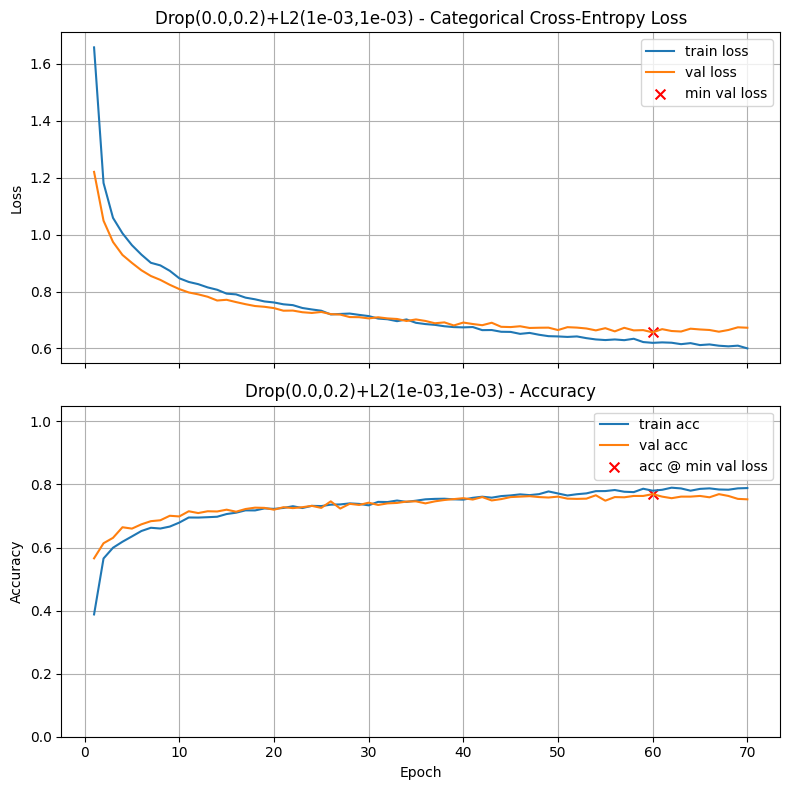

Final Training Loss:            0.6003
Final Training Accuracy:        0.7886
Final Validation Loss:          0.6728
Final Validation Accuracy:      0.7529
Minimum Validation Loss:        0.6565 (Epoch 60)
Validation Accuracy @ Min Loss: 0.7693

Test Loss: 0.6905
Test Accuracy: 0.7557

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:13

Training with Dropout=(0.0, 0.1), L2=(0.001, 0.001)

Drop(0.0,0.1)+L2(1e-03,1e-03)



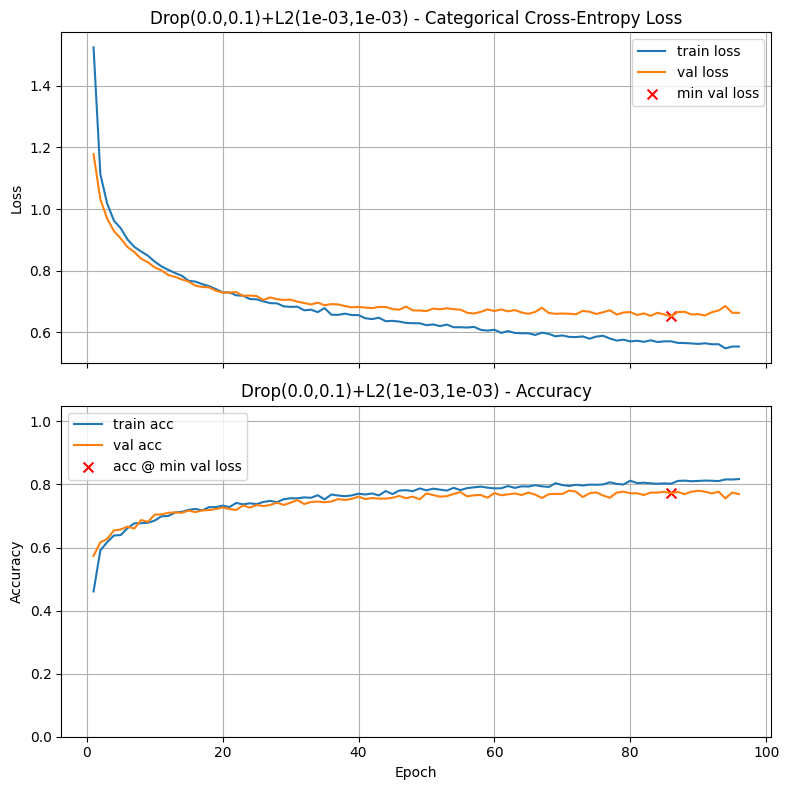

Final Training Loss:            0.5542
Final Training Accuracy:        0.8171
Final Validation Loss:          0.6635
Final Validation Accuracy:      0.7693
Minimum Validation Loss:        0.6521 (Epoch 86)
Validation Accuracy @ Min Loss: 0.7721

Test Loss: 0.6825
Test Accuracy: 0.7564

Validation-Test Gap (accuracy): 0.015714

Execution Time: 00:00:18

Training with Dropout=(0.0, 0.1), L2=(0.0001, 0.0001)

Drop(0.0,0.1)+L2(1e-04,1e-04)



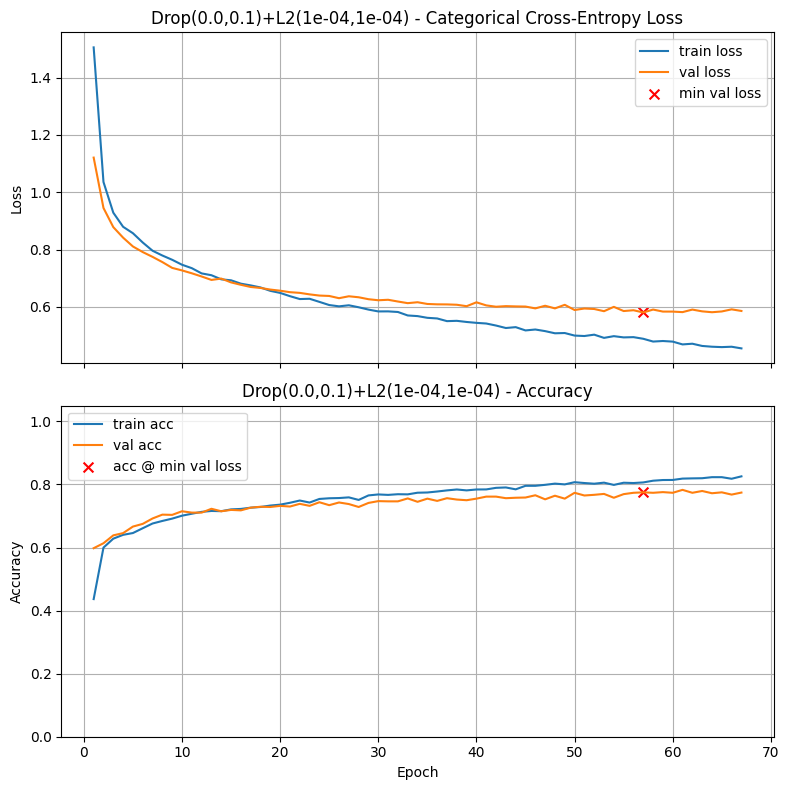

Final Training Loss:            0.4551
Final Training Accuracy:        0.8257
Final Validation Loss:          0.5858
Final Validation Accuracy:      0.7743
Minimum Validation Loss:        0.5804 (Epoch 57)
Validation Accuracy @ Min Loss: 0.7750

Test Loss: 0.6003
Test Accuracy: 0.7543

Validation-Test Gap (accuracy): 0.020714

Execution Time: 00:00:13

Training with Dropout=(0.0, 0.2), L2=(0.01, 0.01)

Drop(0.0,0.2)+L2(1e-02,1e-02)



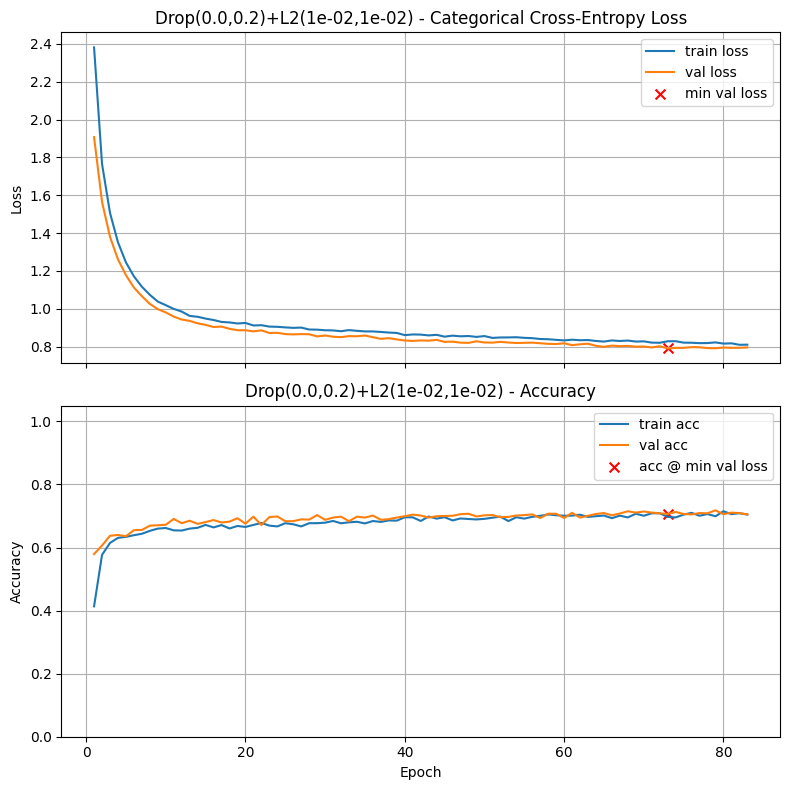

Final Training Loss:            0.8102
Final Training Accuracy:        0.7045
Final Validation Loss:          0.7955
Final Validation Accuracy:      0.7050
Minimum Validation Loss:        0.7906 (Epoch 73)
Validation Accuracy @ Min Loss: 0.7064

Test Loss: 0.8192
Test Accuracy: 0.7064

Validation-Test Gap (accuracy): 0.000000

Execution Time: 00:00:15

Training with Dropout=(0.0, 0.1), L2=(0.01, 0.01)

Drop(0.0,0.1)+L2(1e-02,1e-02)



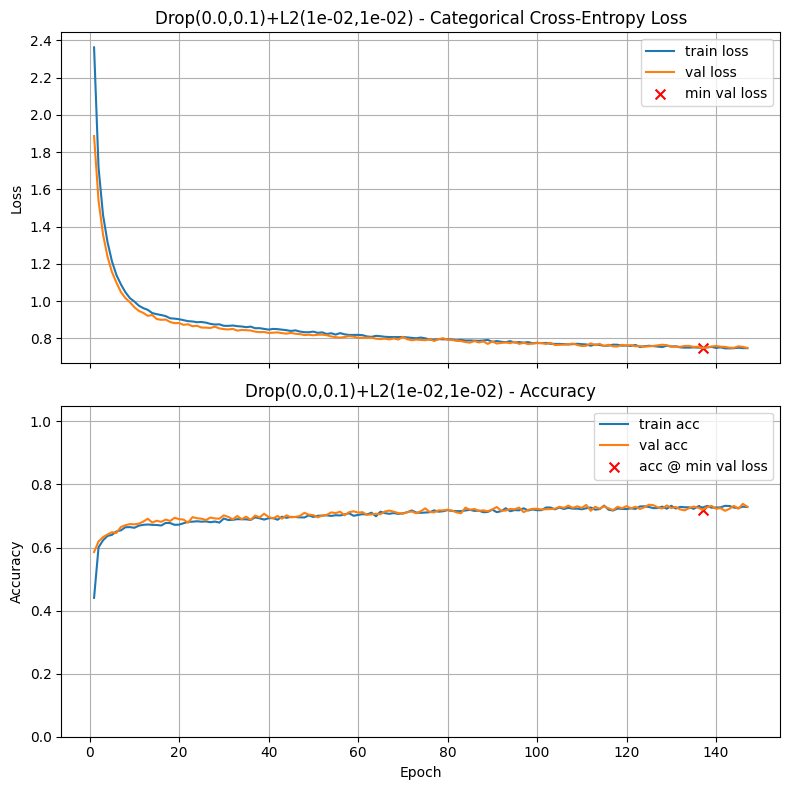

Final Training Loss:            0.7475
Final Training Accuracy:        0.7286
Final Validation Loss:          0.7485
Final Validation Accuracy:      0.7293
Minimum Validation Loss:        0.7477 (Epoch 137)
Validation Accuracy @ Min Loss: 0.7200

Test Loss: 0.7740
Test Accuracy: 0.7136

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:26

PROBLEM 5 RESULTS: Combined Dropout + L2 Regularization
L2 (1e-03, 1e-03)                       	0.7793
L2 (1e-04, 1e-03)                       	0.7793
Drop(0.0,0.3)+L2(1e-03,1e-03)           	0.7793
Drop(0.0,0.1)+L2(1e-04,1e-04)           	0.7750
L2 (0e+00, 0e+00)                       	0.7729
Drop(0.0,0.1)+L2(1e-03,1e-03)           	0.7721
L2 (1e-04, 1e-04)                       	0.7707
Drop(0.0,0.2)+L2(1e-04,1e-04)           	0.7693
Drop(0.0,0.2)+L2(1e-03,1e-03)           	0.7693
Drop(0.0,0.3)+L2(1e-04,1e-04)           	0.7679
L2 (1e-03, 1e-02)                       	0.7621
Drop(0.0,0.3)+L2(0e+00,0e+00)           	0.7543
Drop(0.0,0.3

In [18]:
# Your code here. Add as many cells as you need.


combined_configs = [
    #Baseline: best dropout from Problem 3, no L2
    ((0.0, 0.3), (0.0, 0.0)),
    
    #Add L2 to best dropout configuration
    ((0.0, 0.3), (1e-4, 1e-4)),
    ((0.0, 0.3), (1e-3, 1e-3)), 
    ((0.0, 0.3), (1e-2, 1e-2)),
    
    #Reduce dropout when adding L2 (since both prevent overfitting)
    ((0.0, 0.2), (1e-4, 1e-4)),
    ((0.0, 0.2), (1e-3, 1e-3)),
    ((0.0, 0.1), (1e-3, 1e-3)),
    ((0.0, 0.1), (1e-4, 1e-4)),
    
    #Try some other promising combinations
    ((0.0, 0.2), (1e-2, 1e-2)),
    ((0.0, 0.1), (1e-2, 1e-2)),
]

for (dropout1, dropout2), (l2_1, l2_2) in combined_configs:
    print(f"\nTraining with Dropout=({dropout1}, {dropout2}), L2=({l2_1}, {l2_2})")
    
    baseline_layers = [(64, 'tanh', l2_1, dropout1), (32, 'tanh', l2_2, dropout2)]
    model = build_model(54, baseline_layers, 7)
    
    title = f"Drop({dropout1},{dropout2})+L2({l2_1:.0e},{l2_2:.0e})"
    train_and_test(model, lr_schedule=0.001, title=title)

print("\n" + "="*60)
print("PROBLEM 5 RESULTS: Combined Dropout + L2 Regularization")
print("="*60)
print_results()

In [19]:
# Set a5 to the validation accuracy found by this best combination of dropout and L2 regularization

a5 = 0.7793             # Replace 0.0 with your answer

In [20]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5 = {a5:.4f}') 

a5 = 0.7793


### Problem Six: Build and Train Your Best Model

In this final problem, you will design and train your **best-performing model** using the techniques explored in the previous problems. You may make your own choices for:

* **Model architecture** (number of layers, widths, etc.)
* **Learning rate**
* **Batch size** (a new hyperparameter not varied in earlier problems)
* **Dropout rates** in both layers
* **L2 λ values** in both layers
* **[Optional but strongly suggested]:** Learning rate scheduling, using either **Exponential Decay** or **Cosine Decay**.

  * For Exponential Decay, typical decay rates are **0.90–0.999**, with **0.95** often a good starting point.

**Steps to follow:**

* Build and train the model according to your design choices.
* Use early stopping as before to evaluate performance at the epoch of **minimum validation loss**.
* Answer the graded question.



Training: Best Baseline + LR Scheduling

Best Baseline + LR Scheduling



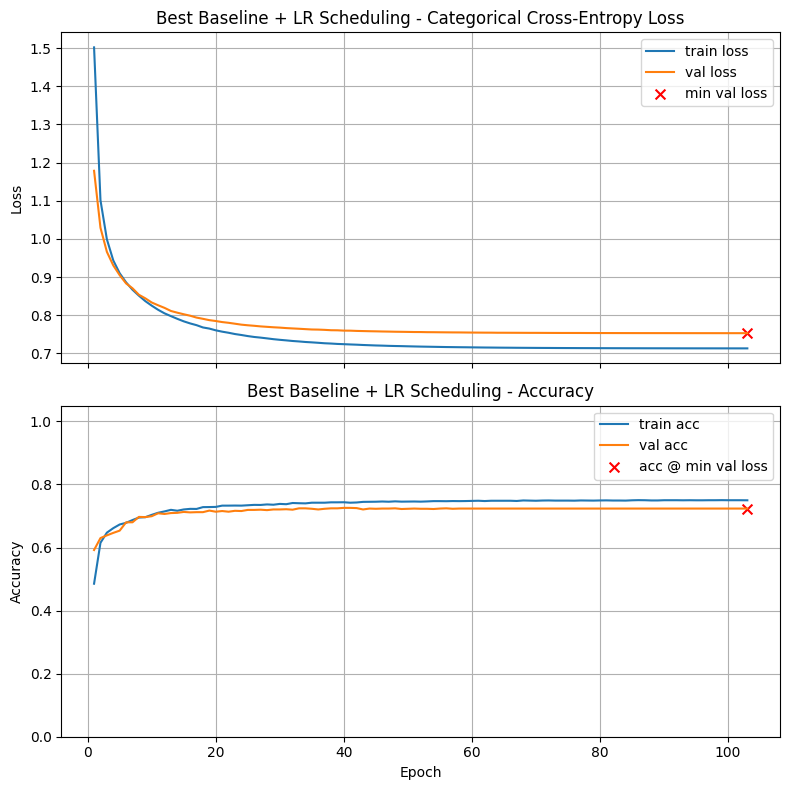

Final Training Loss:            0.7130
Final Training Accuracy:        0.7498
Final Validation Loss:          0.7528
Final Validation Accuracy:      0.7236
Minimum Validation Loss:        0.7528 (Epoch 103)
Validation Accuracy @ Min Loss: 0.7236

Test Loss: 0.7625
Test Accuracy: 0.7171

Validation-Test Gap (accuracy): 0.006429

Execution Time: 00:00:20

Training: Wider Architecture + LR Scheduling

Wider Architecture + LR Scheduling



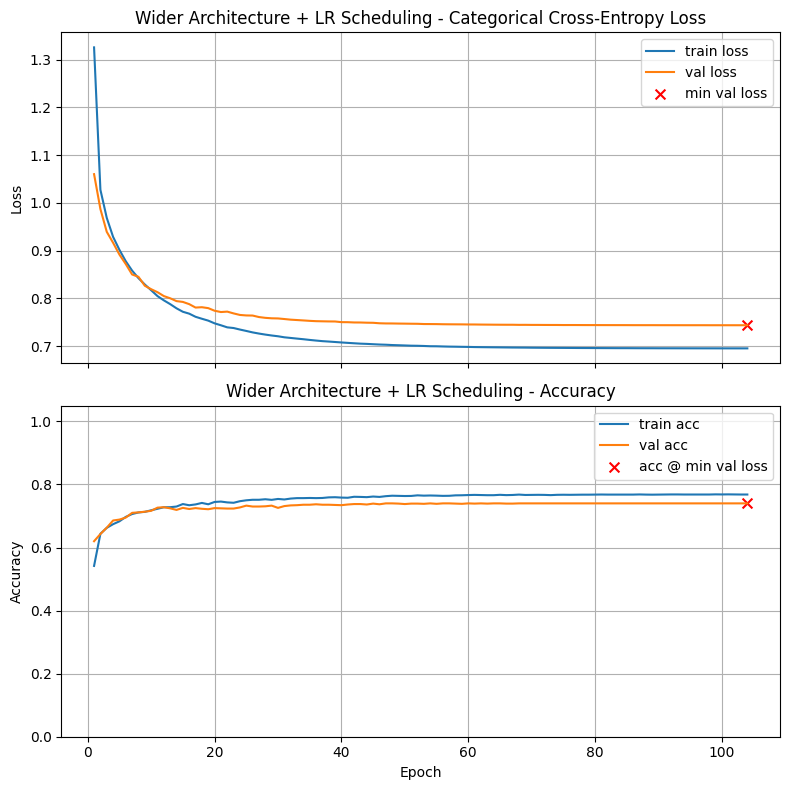

Final Training Loss:            0.6950
Final Training Accuracy:        0.7681
Final Validation Loss:          0.7435
Final Validation Accuracy:      0.7400
Minimum Validation Loss:        0.7435 (Epoch 104)
Validation Accuracy @ Min Loss: 0.7400

Test Loss: 0.7651
Test Accuracy: 0.7264

Validation-Test Gap (accuracy): 0.013571

Execution Time: 00:00:19

Training: Deeper Architecture + LR Scheduling

Deeper Architecture + LR Scheduling



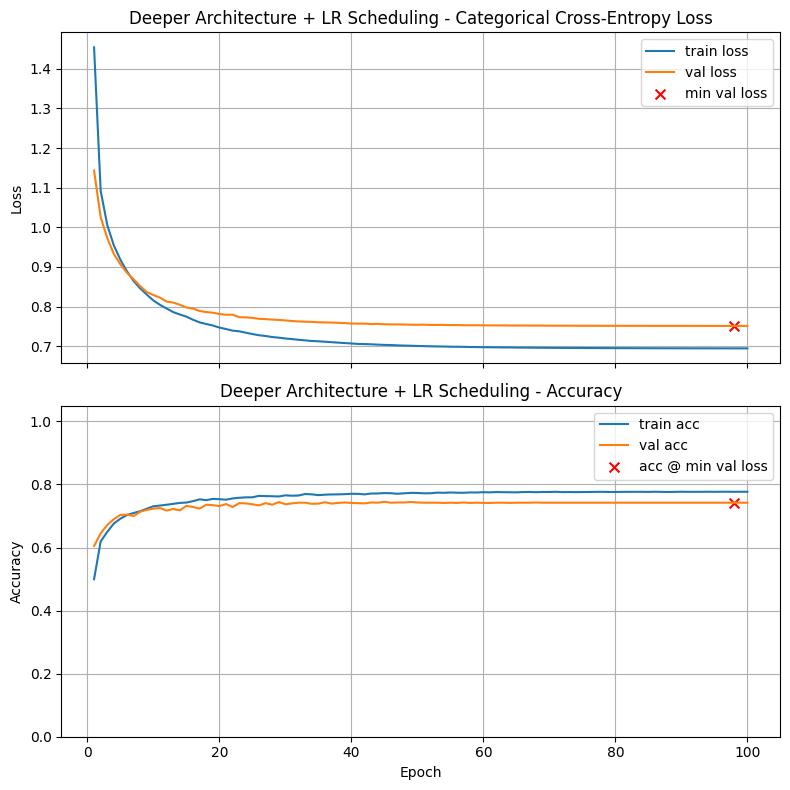

Final Training Loss:            0.6944
Final Training Accuracy:        0.7769
Final Validation Loss:          0.7511
Final Validation Accuracy:      0.7421
Minimum Validation Loss:        0.7511 (Epoch 98)
Validation Accuracy @ Min Loss: 0.7421

Test Loss: 0.7781
Test Accuracy: 0.7200

Validation-Test Gap (accuracy): 0.022143

Execution Time: 00:00:19

Training: Best + Different Batch Size

Best + Different Batch Size



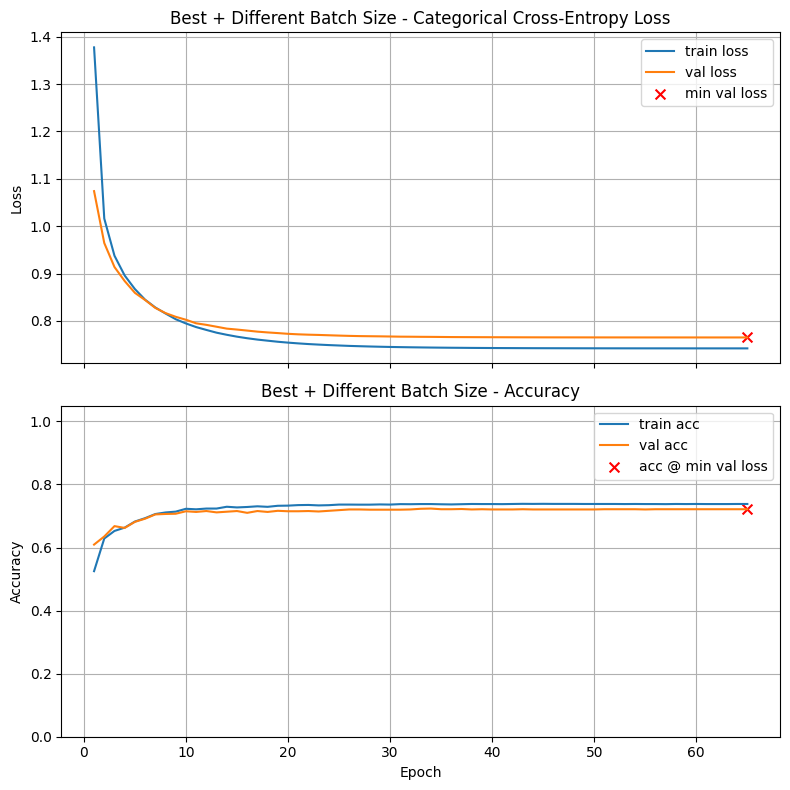

Final Training Loss:            0.7421
Final Training Accuracy:        0.7381
Final Validation Loss:          0.7651
Final Validation Accuracy:      0.7214
Minimum Validation Loss:        0.7651 (Epoch 65)
Validation Accuracy @ Min Loss: 0.7214

Test Loss: 0.7915
Test Accuracy: 0.7250

Validation-Test Gap (accuracy): 0.004286

Execution Time: 00:00:19

Training: Best + Minimal Dropout + LR Scheduling

Best + Minimal Dropout + LR Scheduling



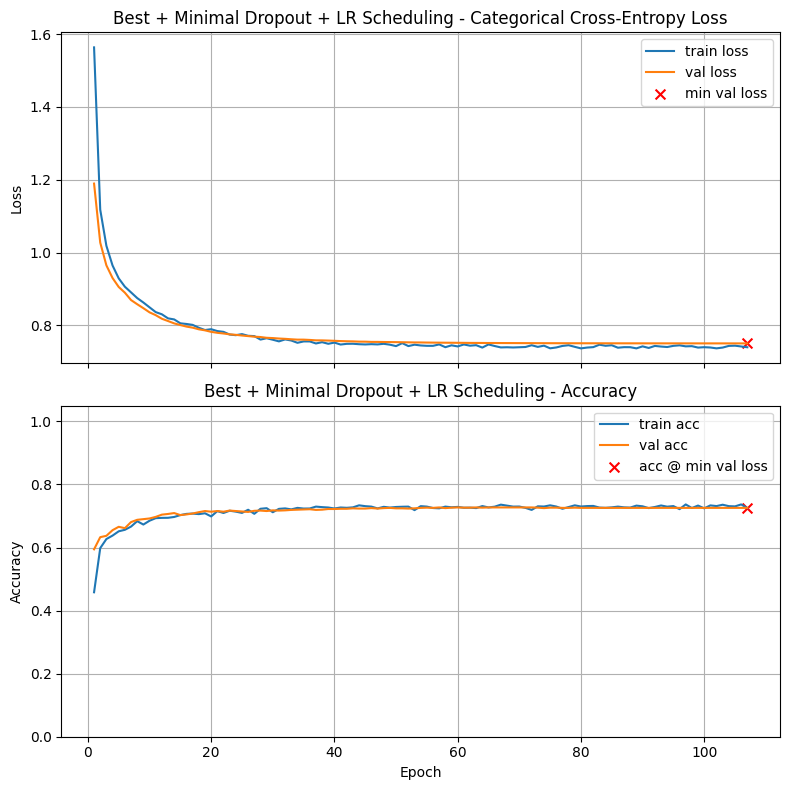

Final Training Loss:            0.7399
Final Training Accuracy:        0.7250
Final Validation Loss:          0.7504
Final Validation Accuracy:      0.7257
Minimum Validation Loss:        0.7504 (Epoch 107)
Validation Accuracy @ Min Loss: 0.7257

Test Loss: 0.7708
Test Accuracy: 0.7200

Validation-Test Gap (accuracy): 0.005714

Execution Time: 00:00:19

PROBLEM 6 RESULTS: Best Model Comparison
L2 (1e-03, 1e-03)                       	0.7793
L2 (1e-04, 1e-03)                       	0.7793
Drop(0.0,0.3)+L2(1e-03,1e-03)           	0.7793
Drop(0.0,0.1)+L2(1e-04,1e-04)           	0.7750
L2 (0e+00, 0e+00)                       	0.7729
Drop(0.0,0.1)+L2(1e-03,1e-03)           	0.7721
L2 (1e-04, 1e-04)                       	0.7707
Drop(0.0,0.2)+L2(1e-04,1e-04)           	0.7693
Drop(0.0,0.2)+L2(1e-03,1e-03)           	0.7693
Drop(0.0,0.3)+L2(1e-04,1e-04)           	0.7679
L2 (1e-03, 1e-02)                       	0.7621
Drop(0.0,0.3)+L2(0e+00,0e+00)           	0.7543
Deeper Architecture + LR Sc

In [21]:
# Your code here

from tensorflow.keras.optimizers.schedules import ExponentialDecay

best_model_configs = [
    {
        'name': 'Best Baseline + LR Scheduling',
        'layers': [(64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.0)],
        'lr_schedule': ExponentialDecay(initial_learning_rate=0.001, decay_steps=50, decay_rate=0.95),
        'batch_size': 64
    },
    {
        'name': 'Wider Architecture + LR Scheduling', 
        'layers': [(128, 'tanh', 1e-3, 0.0), (64, 'tanh', 1e-3, 0.0)],
        'lr_schedule': ExponentialDecay(initial_learning_rate=0.001, decay_steps=50, decay_rate=0.95),
        'batch_size': 64
    },
    {
        'name': 'Deeper Architecture + LR Scheduling',
        'layers': [(64, 'tanh', 1e-3, 0.0), (64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.0)],
        'lr_schedule': ExponentialDecay(initial_learning_rate=0.001, decay_steps=50, decay_rate=0.95),
        'batch_size': 64
    },
    {
        'name': 'Best + Different Batch Size',
        'layers': [(64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.0)],
        'lr_schedule': ExponentialDecay(initial_learning_rate=0.001, decay_steps=50, decay_rate=0.95),
        'batch_size': 32
    },
    {
        'name': 'Best + Minimal Dropout + LR Scheduling',
        'layers': [(64, 'tanh', 1e-3, 0.0), (32, 'tanh', 1e-3, 0.1)],
        'lr_schedule': ExponentialDecay(initial_learning_rate=0.001, decay_steps=50, decay_rate=0.95),
        'batch_size': 64
    }
]

for config in best_model_configs:
    print(f"\nTraining: {config['name']}")
    
    if len(config['layers']) == 2:
        model = build_model(54, config['layers'], 7)
    else:
        layers = [ Input(shape=(54,)) ]
        for (width, act, l2_lambda, dropout_rate) in config['layers']:
            layers.append( Dense(width, activation=act, kernel_regularizer=regularizers.l2(l2_lambda)) )
            if dropout_rate > 0:
                layers.append( Dropout(dropout_rate) )
        layers.append( Dense(7, activation='softmax') )
        model = models.Sequential( layers )
    
    train_and_test(model, 
                  lr_schedule=config['lr_schedule'],
                  batch_size=config['batch_size'], 
                  title=config['name'])

print("\n" + "="*60)
print("PROBLEM 6 RESULTS: Best Model Comparison")
print("="*60)
print_results()

In [22]:
# Set a6 to the validation accuracy found by this best model

a6 = 0.7793             # Replace 0.0 with your answer

In [23]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a6 = {a6:.4f}') 

a6 = 0.7793


### Optional: Print out your results of all experiments

In [48]:
print_results()

## Reflection Questions (ungraded)

1. Activation Functions:

    - Why do you think one activation function worked better than the others for this task?
    
    - How might this choice differ for deeper or wider networks?

2. Learning Rate:

    - Would a much smaller learning rate (with many more epochs) likely produce better accuracy?
    
    - When is it worth training longer with a smaller step size, and when is it unnecessary?

3. Dropout vs. L2:

    - Which form of regularization — dropout or L2 — gave better results in your experiments?
    
    - Why might one method be more effective in this setting?

4. Combining Dropout and L2:

    - Why might the combination of dropout and L2 sometimes perform worse than using one method alone?
    
    - What does this tell you about the balance between bias and variance in regularization?

5. Best Model:

    - When you designed your best model, what trade-offs did you notice between model complexity, training stability, and generalization?
    
    - Did learning rate scheduling (if you tried it) improve results? Why might it help?